# Exploring Data

The purpose of this analysis is to use trial-by-trial information to try to predict the current choice of subjects in a 2-arm bandit task. We have 14 datasets: 7 from a deterministic serial reversal (DSR) task, and the rest from a probabilistic serial reversal (PSR) version. The datasets are for:    

1) subjects with no training (FirstTraining)  
2) subjects halfway thru training (MidTraining)  
3) subjects who are fully trained (Saline)  
4) under bilateral mPFC inactivation (MPFC)  
5) under bilateral OFC inactivation (OFC)  
6) under ipsilateral OFC and mPFC inactivation (Ipsi)  
7) under contralateral OFC and mPFC inactivation (Contra) 

First, we load each dataset and check dimensions:

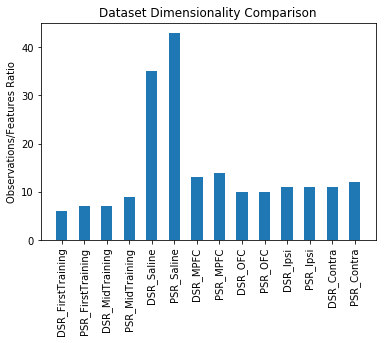

In [17]:
import pickle
import config
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from behavioral_performance.trial_by_trial_dataframe import prepare_dataframe


ROOT = config.ROOT

tasks = ['DSR','PSR']
dataLabels = ['FirstTraining', 'MidTraining', \
              'Saline', 'MPFC', 'OFC', \
              'Ipsi', 'Contra', ]

#retrieving directory and filenames
labels = [task + '_' + dataLabel \
          for dataLabel in dataLabels\
          for task in tasks]
fileNames = [ROOT + '/DATA_structures/' + task + '_TbyT_'  + dataLabel + '.p' \
             for dataLabel in dataLabels \
             for task in tasks]


#go thru each dataset and print info about its size
ratios = []
for fileName in fileNames:
    df = pickle.load(open(fileName, 'rb'))
    df = prepare_dataframe(df)
    ratios.append(np.float(df.shape[0]/df.shape[1]))
    
x = np.arange(0.5, len(ratios) + 0.5)

fig, axes = plt.subplots()

plt.bar(x, ratios, 0.5)
plt.xticks(x, labels, rotation = 90)
plt.ylabel('Observations/Features Ratio')
plt.title('Dataset Dimensionality Comparison')
plt.show()

OK. The ratio of observations to features is at least(ish) 10 for all datasets. This is good, but we will still look thru the feature space and attempt some dimensionality reduction. Why ? For actual classification we will use neural networks, which are often slow, so reducing the dimensionality of the input may help. We are also hoping to improve the quality of the features. Also, some features are definitely colinear. 

## What the Data Looks Like

So what does the data contain ? Most of the features are categorical. Only RTs (reaction times) are not. 
Here is a list explaining the different independent variables:    

RT1 = Reaction time to initiate trial (in seconds) 
RT2 = Reaction time to make a choice (in seconds)
SA = Start Arm  (South = 0, North = 1)  
GA = Goal Arm  (East = 0, West = 1)  
Choice = (East = 0, West = 1)  
Reward = (No Reward = 0, Reward = 1)  
Congruent = (Correct AND reward) OR (Incorrect AND no reward) = 1, 0 otherwise. Applies to PSR only
Choice_AR = (0 = No Reward, 1 = East AND Reward, -1 = West AND Reward)  
Win-Stay = (1 = If received a reward for a particular choice in the last trial and choice was repeated, 0 if it was not repeated)  
Lose-Shift = (1 = If received no reward in the last trial and that choice was not repeated, 0 if it was repeated)    

These measures are taken for the last 10 trials and current trial. Below we show sample data for 2 and 3 trials ago. 

In [25]:
#load DSR Saline Dataframe
df = pickle.load(open(fileNames[4], 'rb'))

#useful tool for getting a smaller subset of the data
idx = pd.IndexSlice

#we first have to sort the multi-index of the dataframe to be able to use IndexSlice
df.sort_index(axis = 0, inplace = True)
df.sort_index(axis = 1, inplace = True)

#show the data.
df.head()

type                  GA                                         ... winStay  \
trials_ago            0    1    2    3    4   5   6   7   8   9  ...      1    
session block trial                                              ...           
S0      B1    0      0.0  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN ...     NaN   
              1      0.0  0.0  NaN  NaN  NaN NaN NaN NaN NaN NaN ...     NaN   
              2      0.0  0.0  0.0  NaN  NaN NaN NaN NaN NaN NaN ...     0.0   
              3      0.0  0.0  0.0  0.0  NaN NaN NaN NaN NaN NaN ...     0.0   
              4      0.0  0.0  0.0  0.0  0.0 NaN NaN NaN NaN NaN ...     0.0   

type                                                       
trials_ago            2    3   4   5   6   7   8   9   10  
session block trial                                        
S0      B1    0      NaN  NaN NaN NaN NaN NaN NaN NaN NaN  
              1      NaN  NaN NaN NaN NaN NaN NaN NaN NaN  
              2      NaN  NaN NaN NaN NaN NaN NaN NaN NaN  
              3      0.0  NaN NaN NaN NaN NaN NaN NaN NaN  
              4      0.0  0.0 NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 110 columns]

Notice that on trial 0, all the values are NaN. This is because there are no trials before trial 0. 
So for the first 10 trials of every session, there will be some data missing. This is important because the neural network classifier we use later does not tolerate missing data, so we have no option but to discard the first 10 trials of each session. In general, if we include data from the last K trials, this means we will have to discard the first K trials of every session.  

OK, now let's do some visualization. Let's start with the only continuous variable:

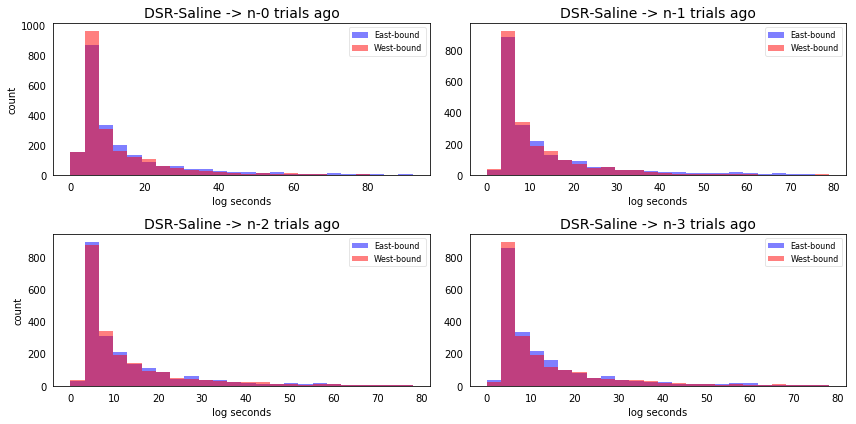

In [19]:

#labels are the choice on the current trial (trial 0)
y = df.loc[:,idx['choice',0]]
#labels for each choice
label_dict = {0:'East', 1:'West'}


def clean_RTs(RT):
    #remove outliers
    mu = RT.mean()
    sigma = RT.std()
    RT = RT[RT < mu + 2*sigma]
    RT = RT[RT > mu - 2*sigma]
    return RT


dataset = 'DSR-Saline'
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))


for ax,cnt in zip(axes.ravel(), range(4)):  
    
    RT = df.loc[:,idx['RT1', cnt]]
    RT = clean_RTs(RT)
    
    # set bin sizes
    min_b = np.floor(np.min(RT))
    max_b = np.ceil(np.max(RT))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(2), ('blue', 'red')):
        ax.hist(RT[y==lab],
                color=col,
                label='%s-bound' %label_dict[lab],
                bins=bins,
                alpha=0.5)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel('log seconds')
    ax.set_title('%s -> n-%i trials ago' %(dataset,cnt), FontSize=14)

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")
 

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()


OK. So not a huge difference between reaction times and whether an animal made an East or West choice. 
Now let's try some of the other variables. We are going to try 4 variables, from the previous trial: goal arm (GA), start arm (SA), choice, and outcome. Since SA is supposed to be random, we expect to have no correlation here. GA is a variable that says what the actual correct answer was, so we expect it to be correlated with its respective choice since animals were performing above chance. Choice will probably be correlated also, since once animals performed 'stably' they would tend to repeat their choice. Outcome should not be correlated because we lack the information of where this outcome occurred. Let's check and see what happens:

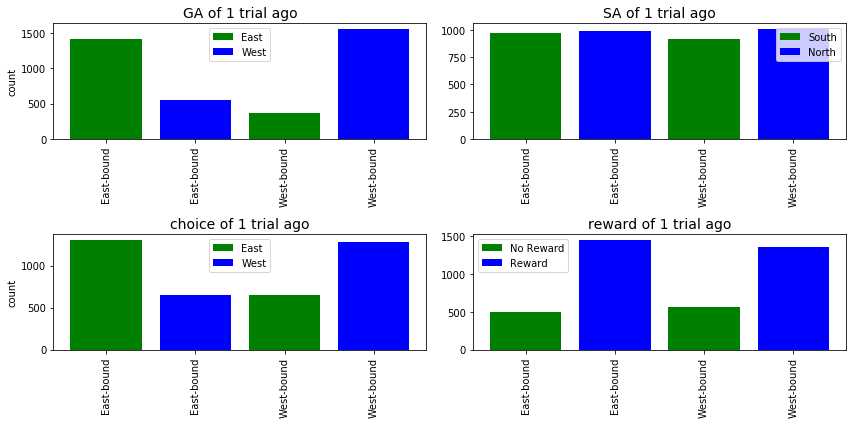

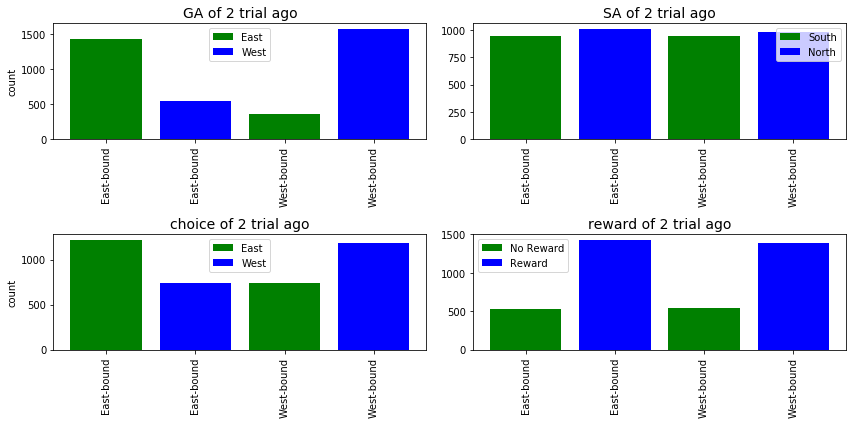

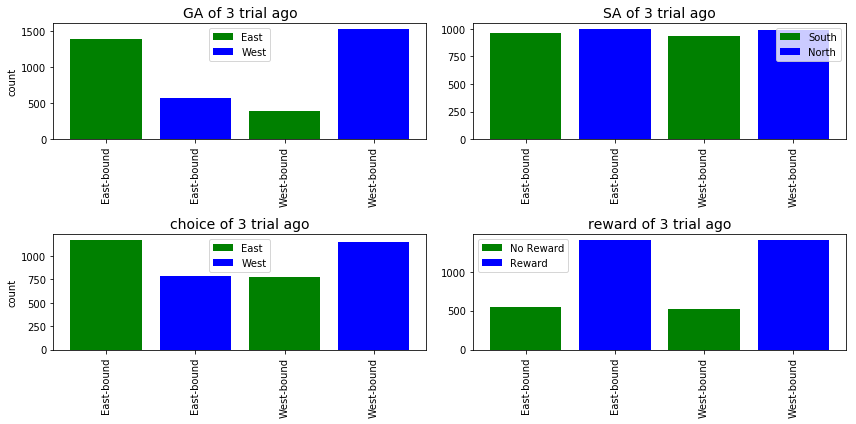

In [26]:
#(re)load DSR Saline Dataframe
df = pickle.load(open(fileNames[4], 'rb'))

#small fix, throw away all rows with NaN values
df.dropna(axis=0, inplace=True)


#variables of interest
my_vars = ['GA','SA','choice','reward']
#labels
journey_labels = ['East-bound','East-bound','West-bound','West-bound']
var_labels = {'GA': ['East','West'],
              'SA': ('South','North'),
              'choice':('East','West'),
              'reward':('No Reward','Reward')}

#labels are the choice on the current trial (trial 0)
y = df.loc[:,idx['choice',0]]



#only looking at data from 1 trial ago
for trial in [1,2,3]:


    #shiny new plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

    #plotting each subplot
    for ax,cnt in zip(axes.ravel(), range(4)):  


        #separating data into East-bound and West-bound
        datasets = [df.loc[y==journey, idx[my_vars[cnt], trial]] for journey in range(2)]
        #getting counts
        heights = [np.sum(sub_df==w) for sub_df in datasets for w in range(2)]


        x = [0, 0.25, 0.5, 0.75]
        ax.set_xticks(x)
        ax.bar(x[::2], heights[::2], 0.2, color=['g'])
        ax.bar(x[1::2], heights[1::2], 0.2, color=['b'])
        ax.set_xticklabels(journey_labels, rotation=90)


        ax.set_title('%s of %i trial ago' %(my_vars[cnt], trial) , FontSize=14)
        ax.legend(var_labels[my_vars[cnt]])


    axes[0][0].set_ylabel('count')
    axes[1][0].set_ylabel('count')

    fig.tight_layout()       

    plt.show()

From playing around with the different datasets, there is one plot that jumps out markedly. Reward of n trials ago shows a HUGE bias against choosing East, which should show up on the other plots and it's not. Something is wrong, and now we need to troubleshoot.    
[EDIT]: Fixed Mistake. Reason it didn't show up on other datasets is because they were symmetrical. 

In [8]:
#CODE FOR TROUBLESHOOTING ABOVE
for cnt in range(4):

    #separating data into East-bound and West-bound
    datasets = [df.loc[y==journey, idx[:, :]] for journey in range(2)]
    
    #lets check that these datasets are what we think they are:
    for sub_df in datasets:
        east_count = np.sum(sub_df.loc[:,idx['choice',0]] == 0)
        #we should see east trials = total trials, and then 0, alternating
        print 'east trials:%i\ttotal trials:%i' %(east_count, sub_df.shape[0])
    
        #get appropriate columns:
        sub_zero = np.sum(sub_df.loc[:, idx[my_vars[cnt], trial]] == 0)
        sub_one = np.sum(sub_df.loc[:, idx[my_vars[cnt], trial]] == 1)
        print '%i + %i = %i (supposed to be: %i)' %(sub_zero,sub_one,sub_zero+sub_one,sub_df.shape[0])
  
    

east trials:1948	total trials:1948
1384 + 564 = 1948 (supposed to be: 1948)
east trials:0	total trials:1914
390 + 1524 = 1914 (supposed to be: 1914)
east trials:1948	total trials:1948
953 + 995 = 1948 (supposed to be: 1948)
east trials:0	total trials:1914
928 + 986 = 1914 (supposed to be: 1914)
east trials:1948	total trials:1948
1168 + 780 = 1948 (supposed to be: 1948)
east trials:0	total trials:1914
777 + 1137 = 1914 (supposed to be: 1914)
east trials:1948	total trials:1948
546 + 1402 = 1948 (supposed to be: 1948)
east trials:0	total trials:1914
523 + 1391 = 1914 (supposed to be: 1914)


OK, we did find a bug here! We were throwing out a lot of data, namely the first 10 trials of every block! We
only want to throw away the first 10 trials of the session, not of every block. This is not a waste of time. Let's
keep going, this does not explain the weird bias, which is still there. We are going to see if the # of west-bound and east-bound trials changes accross conditions, which it shouldn't. If it doesn't, I may consider beleiving this result

In [6]:
#CODE FOR TROUBLESHOOTING ABOVE
for cnt in range(4):

    #separating data into East-bound and West-bound
    datasets = [df.loc[y==journey, idx[:, :]] for journey in range(2)]

   
    #getting counts
    heights = [np.sum(sub_df.loc[:, idx[my_vars[cnt], trial]]==w) for w in range(2) for sub_df in datasets]
    print 'East bound:%i\tWest bound:%i' %(np.sum(heights[:2]), np.sum(heights[2:]))

East bound:1774	West bound:2088
East bound:1881	West bound:1981
East bound:1945	West bound:1917
East bound:1069	West bound:2793


OK, I think we found the actual bug! These values should be equal accross conditions. We can trace the mistake to these nested lists, so that the first one is the outer "for-loop", not the other way around. The following should work. 

In [7]:
#CODE FOR TROUBLESHOOTING ABOVE
for cnt in range(4):

    #separating data into East-bound and West-bound
    datasets = [df.loc[y==journey, idx[:, :]] for journey in range(2)]

   
    #getting counts
    heights = [np.sum(sub_df.loc[:, idx[my_vars[cnt], trial]]==w) for sub_df in datasets for w in range(2) ]
    print 'East bound:%i\tWest bound:%i' %(np.sum(heights[:2]), np.sum(heights[2:]))

East bound:1948	West bound:1914
East bound:1948	West bound:1914
East bound:1948	West bound:1914
East bound:1948	West bound:1914


And it does. Now we go back and correct the result above. OK, finally we can comment on this. We can see that things like start arm (SA) or 'reward' on its own does not help separate East-bound from West-bound trials. Past choices and goal arms (GA) are quite good at predicting current choice. 

# Random Forest Feature Selection

So let's try this. We have 110 features in total, but some of them we're gonna exclude by hand. Why ? Since ultimatly what we want to decode is the choice of the animal, we will start by *only* using information that was available to the rat. This excludes GA (which is the actual answer), and congruent (which includes information about the correct answer). 

We are left with 80 features. Random Forest classifier is an ensemble method that uses k decision trees in parallel. Each decision tree starts at a node with a particular feature and asks whether once we separate the data into its respective classes, whether there was any information gain. If so, this was a good split as it helped in classification and then we go down that node and try to separate the data again. Let's first understand how the decision tree works.  

First 

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from behavioral_performance.trial_by_trial_dataframe import prepare_dataframe

#useful as always
idx = pd.IndexSlice

#this was throwing annoying warnings which were unrelated so...
pd.options.mode.chained_assignment = None  # default='warn'


def retrieve_dataframe(fileName):
    #load dataset
    df = pickle.load(open(fileName, 'rb'))
    #throw out first T trials, center RT columns
    df = prepare_dataframe(df)

    #y is always idx['choice',0] - current choice - we do not change
    y = df.loc[:, idx['choice',0]]
    #only include variables that were available to the rat
    X = df.loc[:, idx[['winStay', 'loseShift', 'choice', 'reward', 'SA', 'RT1', 'RT2', 'choice_AR'], 1:]]
    
    return X,y

fileName = fileNames[4]
X,y = retrieve_dataframe(fileName)
print '# of features: %i' %X.shape[1]


# of features:80


So we have our datasets ready to go, hand-picking variables for this first pass reduced the number down to 50 as well. OK, now let's naively just run a decision-tree, python makes this pretty easy. 

In [43]:
from sklearn import tree

def get_dataset_name(fileName):
    fileName = fileName[-fileName[::-1].find('/'):]
    return fileName[:fileName.find('.')]

def test_tree(clf, X, y):
    #split dataset into train and test sets: 60/40
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)
        
    scores = []
    for runs in range(10):
        # Train the classifier
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    return np.nanmean(scores)
       
# Create decision tree with default values for now (using gini score)
clf = tree.DecisionTreeClassifier()

#go thru every dataset
for fileName in fileNames:
    X,y = retrieve_dataframe(fileName)
    print 'dataset: %s' %get_dataset_name(fileName)
    print 'average score on test set: %1.3f' %test_tree(clf, X, y)
    
    


dataset: DSR_TbyT_FirstTraining
average score on test set: 0.593
dataset: PSR_TbyT_FirstTraining
average score on test set: 0.609
dataset: DSR_TbyT_MidTraining
average score on test set: 0.561
dataset: PSR_TbyT_MidTraining
average score on test set: 0.495
dataset: DSR_TbyT_Saline
average score on test set: 0.656
dataset: PSR_TbyT_Saline
average score on test set: 0.583
dataset: DSR_TbyT_MPFC
average score on test set: 0.643
dataset: PSR_TbyT_MPFC
average score on test set: 0.632
dataset: DSR_TbyT_OFC
average score on test set: 0.641
dataset: PSR_TbyT_OFC
average score on test set: 0.550
dataset: DSR_TbyT_Ipsi
average score on test set: 0.603
dataset: PSR_TbyT_Ipsi
average score on test set: 0.593
dataset: DSR_TbyT_Contra
average score on test set: 0.604
dataset: PSR_TbyT_Contra
average score on test set: 0.577


A decision tree is probabilistic so it gives different values every time you run it, so score is averaged over 10 runs. Scores are slightly above chance, so not great.  

So, as a test, let's see *which* variables may be contributing the most by only using one kind per classification problem as below:

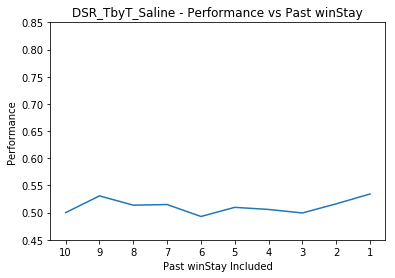

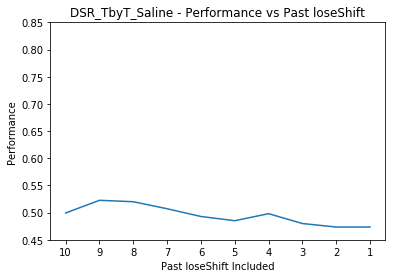

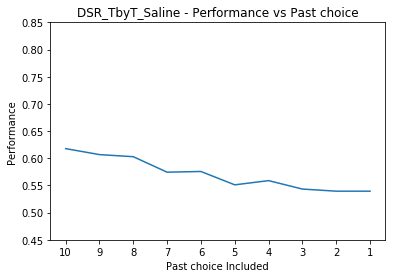

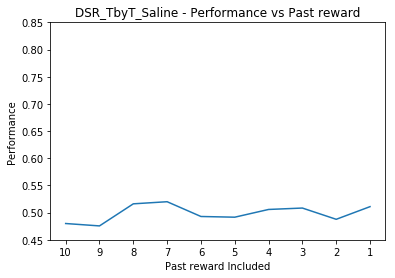

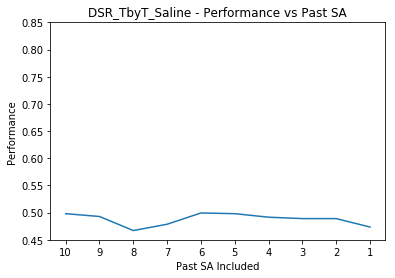

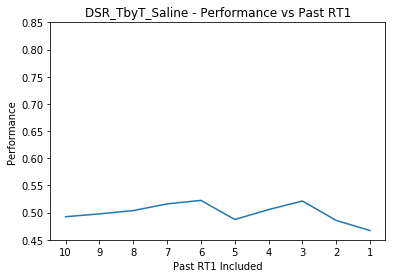

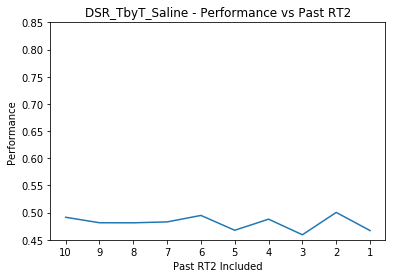

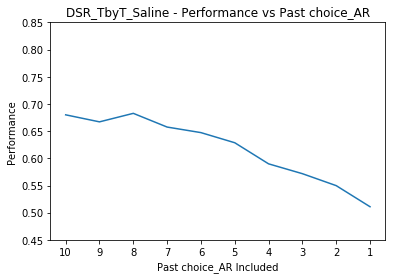

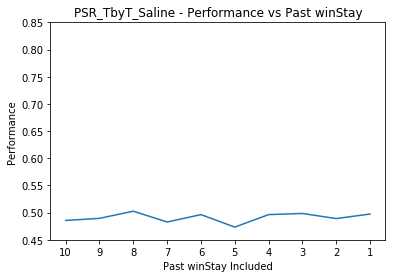

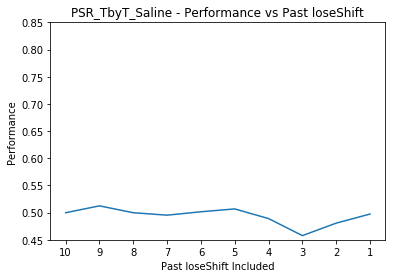

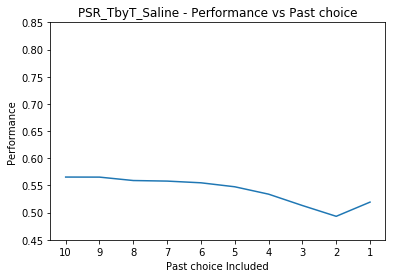

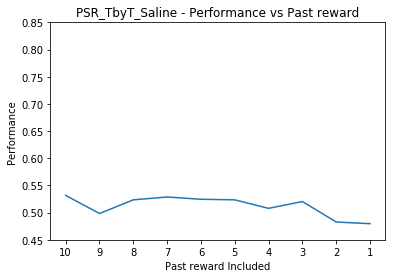

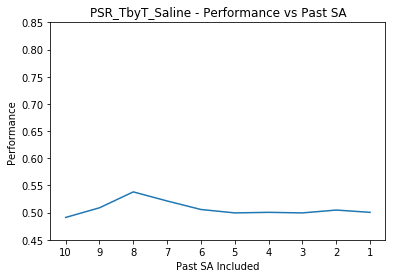

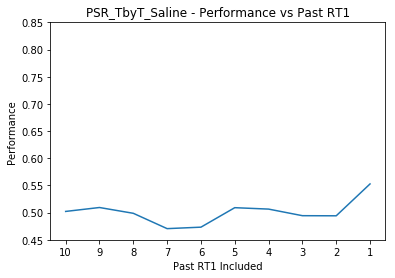

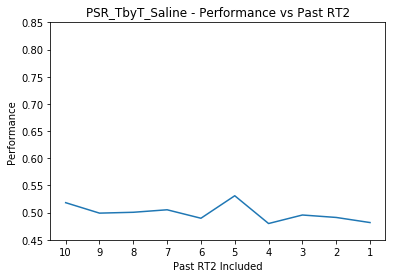

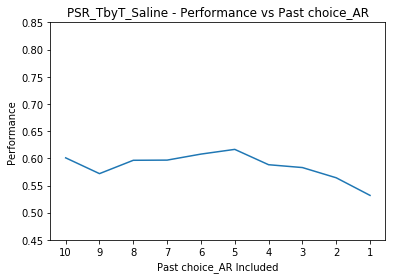

In [44]:


def test_single_var(clf, df, term, title, T = 10):
    
    scores = np.zeros([1,T], dtype=float)
    
    #y is always idx['choice',0] - current choice - we do not change
    y = df.loc[:, idx['choice',0]] 

    for trial in range(1, 1 + T):
        #only information from the past
        X = df.loc[:, idx[term, trial:]]   
        
        #let's test tree now
        scores[0, trial - 1] = test_tree(clf, X,y)


    plt.plot(range(1, 1 + T), scores.ravel())
    plt.ylim([0.45,0.85])
    plt.xticks(range(1, 1 + T), range(1, 1 + T)[::-1])
    plt.xlabel('Past %s Included' %term)
    plt.ylabel('Performance')
    plt.title('%s - Performance vs Past %s' %(title, term))
    plt.show()



# Create decision tree with default values for now (using gini score)
clf = tree.DecisionTreeClassifier()

#go thru every dataset
for fileName in fileNames[4:6]:
    #load dataset
    df = pickle.load(open(fileName, 'rb'))
    #throw out first T trials, center RT columns
    df = prepare_dataframe(df)
    
    for term in ['winStay', 'loseShift', 'choice', 'reward', 'SA', 'RT1', 'RT2', 'choice_AR']:
        #test single variable
        test_single_var(clf, df, term, get_dataset_name(fileName))
    

OK, so most of the heavy lifting is done by the features 'choice' and 'choice_AR', which makes total sense. Most variables on their own will keep the classifier at chance, so that probably means that they don't contribute very much. That's what we're looking for, in order to reduce the number of features that we consider.  

We are running the decision tree with default setting. Now we want to see whether we can improve predictive power of an individual decision tree before turning to the random forest. 

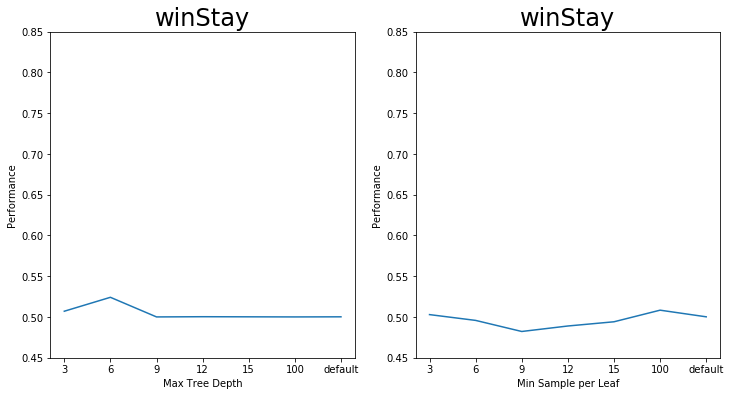

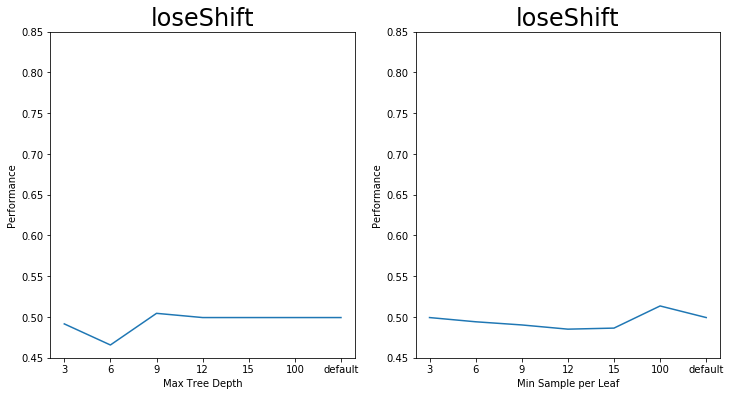

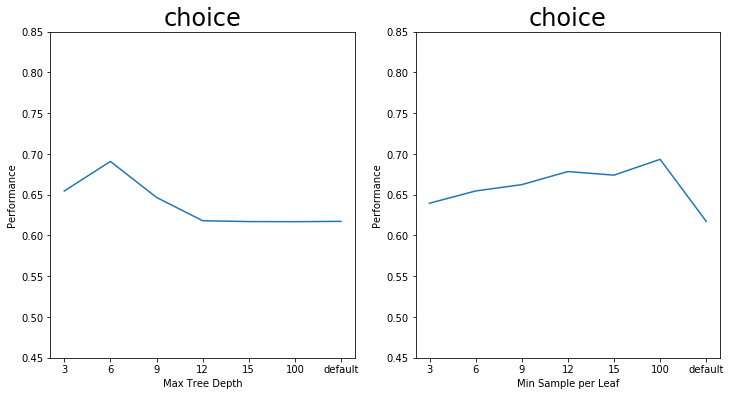

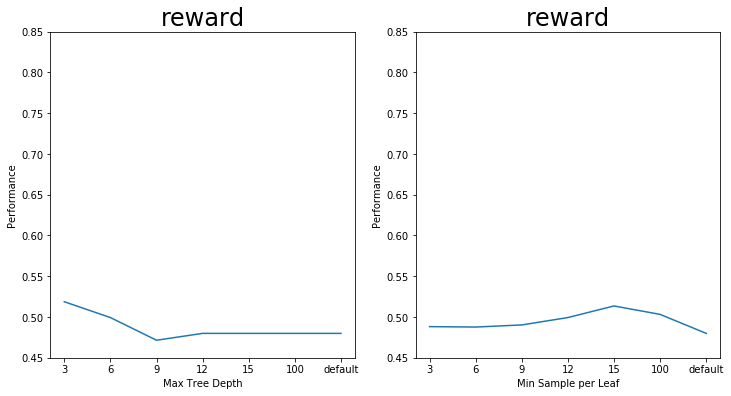

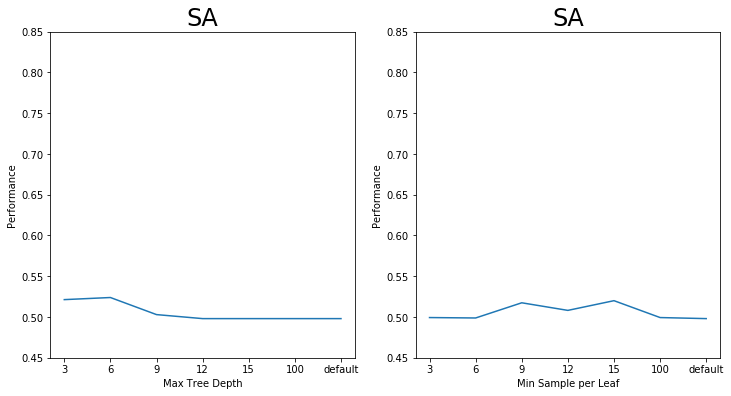

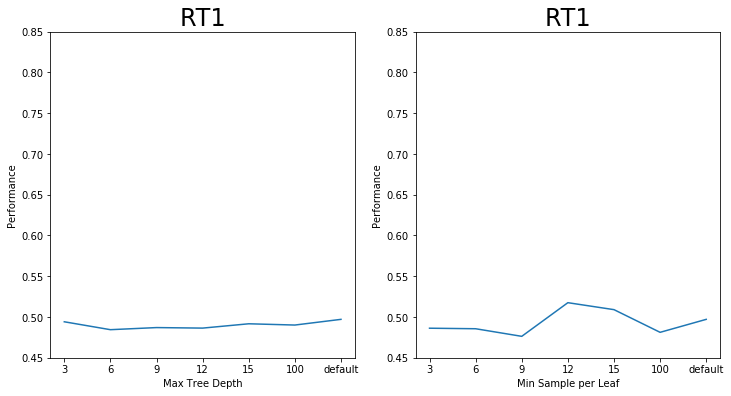

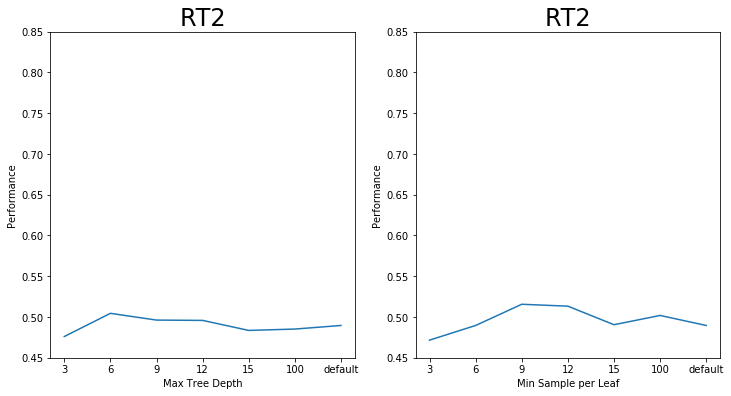

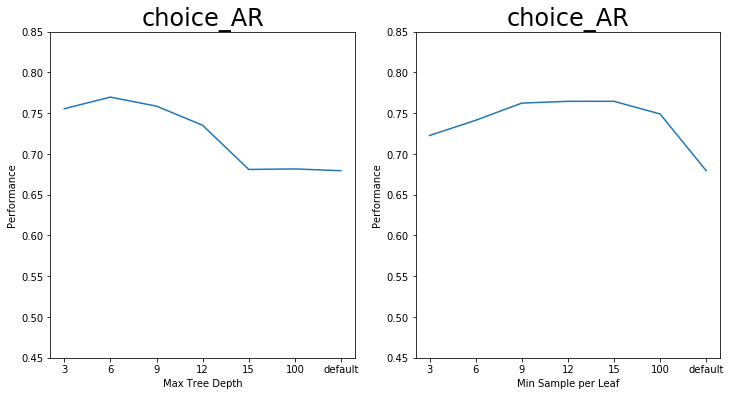

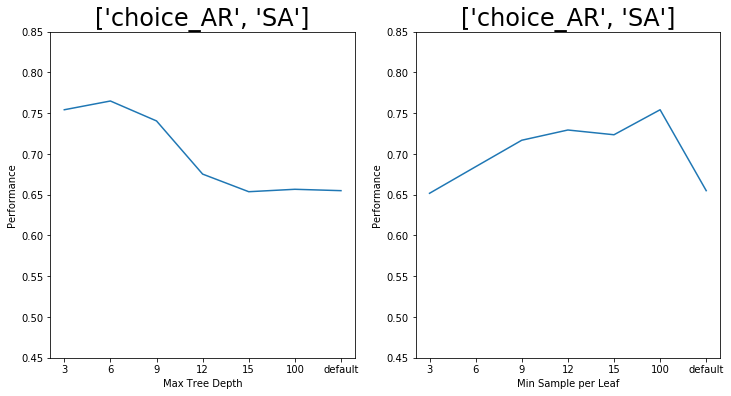

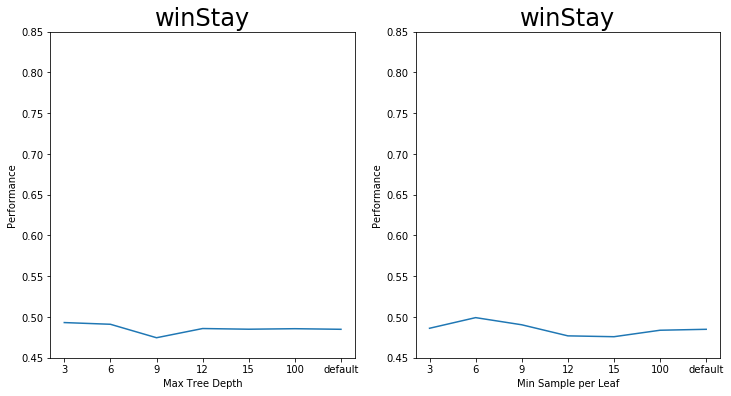

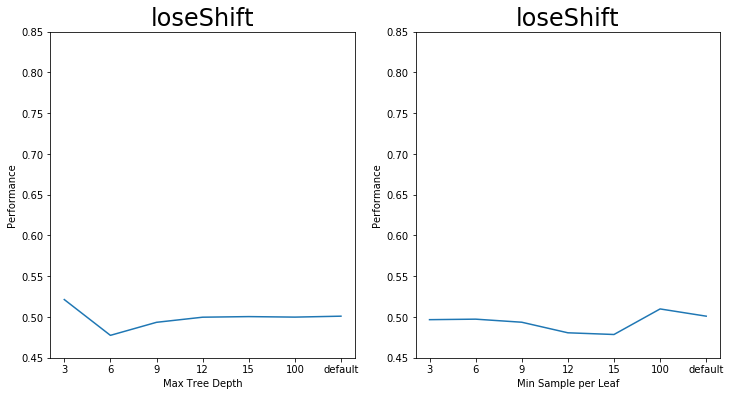

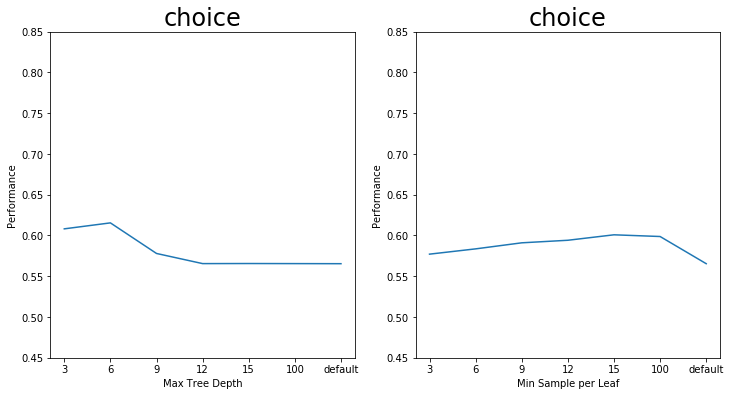

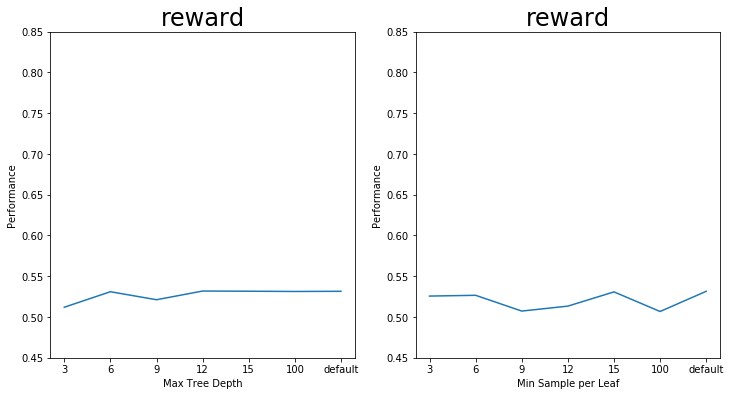

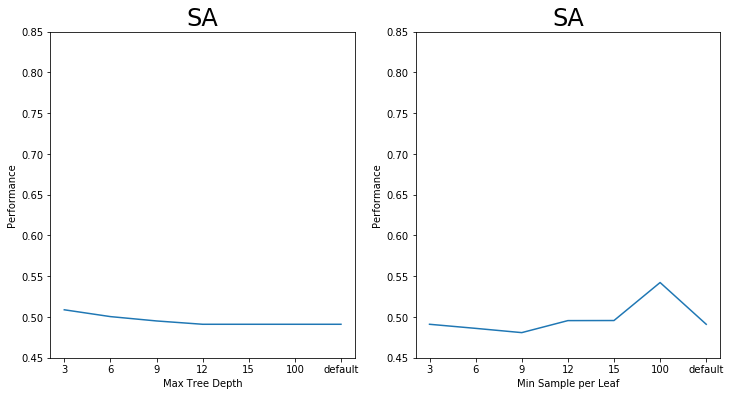

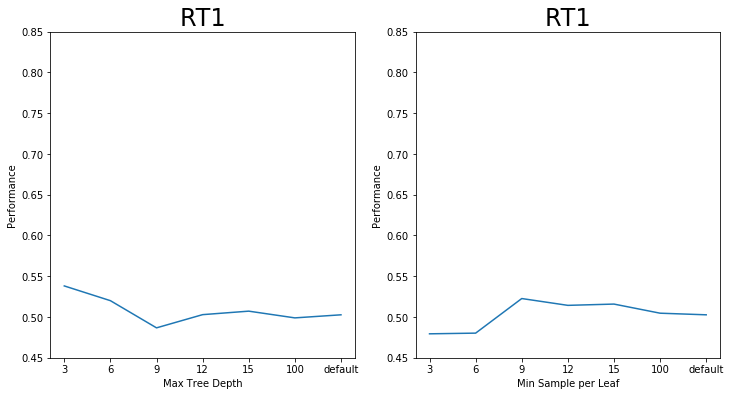

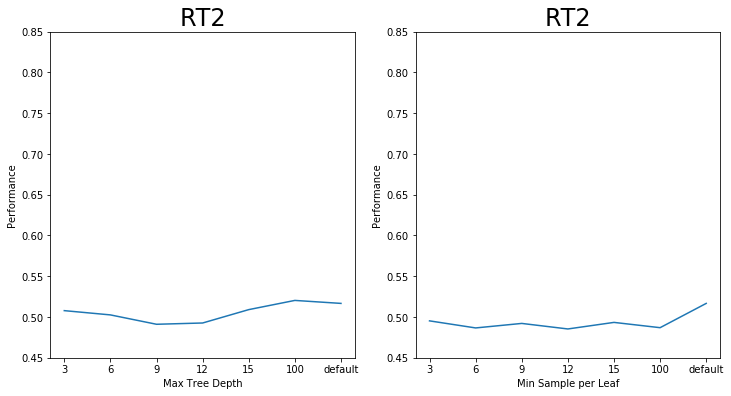

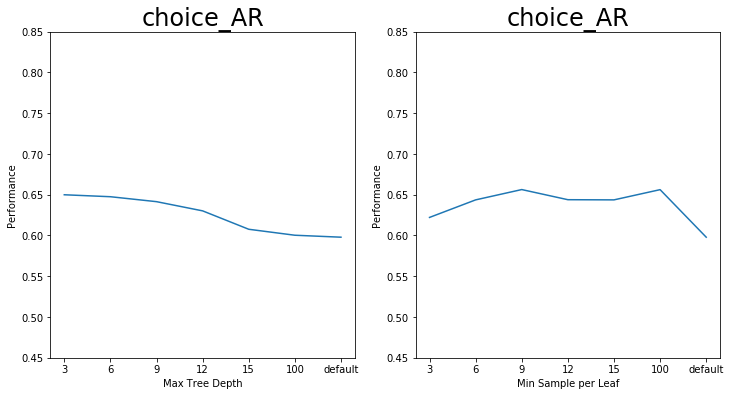

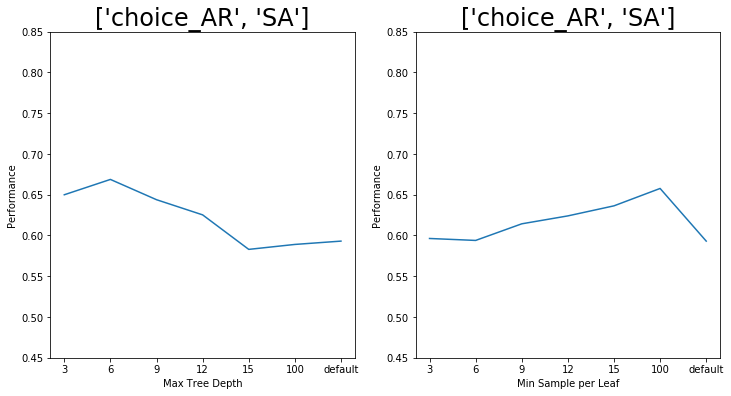

In [53]:
#visualize tree depth and min samples per leaf against performance
def vary_depth_leaf(X, y, term, title):
    
    my_range = np.r_[np.arange(3,16,3), 100]
    scores = np.zeros([2, 1 + len(my_range)], dtype=float)    
    
    #trim down X to relevant term
    X = X.loc[:, idx[term, :]] 
    for D_index, D in enumerate(my_range):
        #varying max depth, keeping min_samples_leaf default (1)
        clf = tree.DecisionTreeClassifier(max_depth = D)
        scores[0, D_index] = test_tree(clf, X, y)
        
        #varying min_samples_leaf, keeping depth at default (unlimited)
        clf = tree.DecisionTreeClassifier(min_samples_leaf = D)
        scores[1, D_index] = test_tree(clf, X, y)  
        
    #also want to test the default
    clf = tree.DecisionTreeClassifier()
    scores[:, -1] = test_tree(clf, X, y)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    labels = ['Max Tree Depth','Min Sample per Leaf']
    x_labels = list(my_range); x_labels.append('default')

    for ax_index, ax in enumerate(axes.ravel()):
        ax.plot(range(1 + len(my_range)), scores[ax_index].ravel())
        ax.set_ylim([0.45,0.85])
        
        ax.set_xticks(range(1 + len(my_range)))
        ax.set_xticklabels(x_labels)
        ax.set_xlabel(labels[ax_index])
        ax.set_ylabel('Performance')
        ax.set_title(title, FontSize=24)
    plt.show()


#go thru a couple of datasets
for fileName in fileNames[4:6]:
    X,y = retrieve_dataframe(fileName)
    #still go term by term to see what happens
    
    for term in ['winStay', 'loseShift', 'choice', 'reward', 'SA', 'RT1', 'RT2', 'choice_AR', ['choice_AR','SA']]:
        vary_depth_leaf(X, y, term, term)
        

We can see the classifier is sensitive to the minimum samples per leaf. The default is 1, so in this case it's trying to split the tree as much as possible which ends up hurting performance. This is probably because the more split the tree is, the more it is overfitting and thus generalizing poorly to the test set.  

As far as max tree depth, we see a similar theme. The more the tree is allowed to split, the more performance drops! Again, this is probably due to poor generalization to the test set. 

What we learned here is that our trees don't need to have huge depth, or very small # of samples per leaf, probably so they can generalize better. The Random Forest classifier takes step to improve generalization anyways, so it may be fine for each tree in the forest to try to overfit whatever data it gets, but since we already did this bit of prep work I don't see why we shouldn't incorporate that later. Ultimately, all of this is for feature selection.  

ALSO, we see again that choice and choice_AR are doing all the heavy lifting. Furthermore, if we add a seemingly non-predictive variable to choice_AR such as SA this effect is even bigger. So, with bigger depth, with bad variables the tree has worse performance. With smaller samples per leaf, if there are bad variables present, the classifier will do worse.  

And finally, just one last run for ALL datasets including ALL the features:

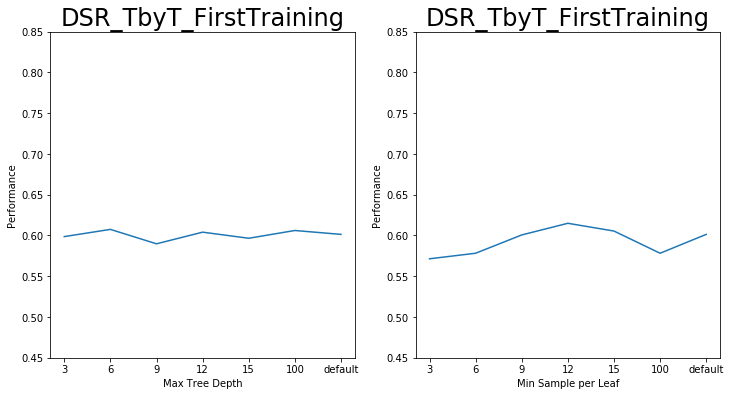

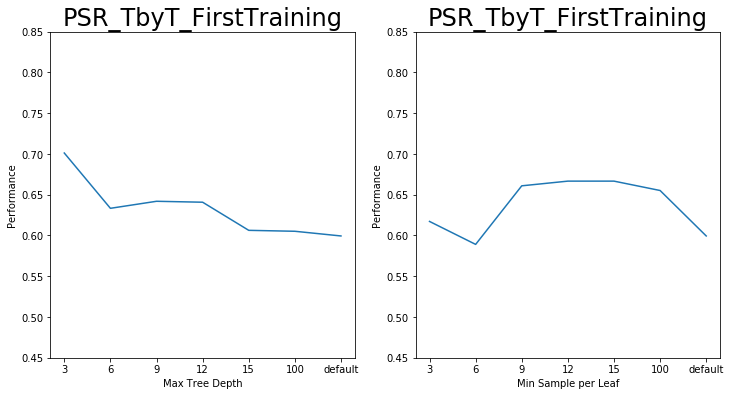

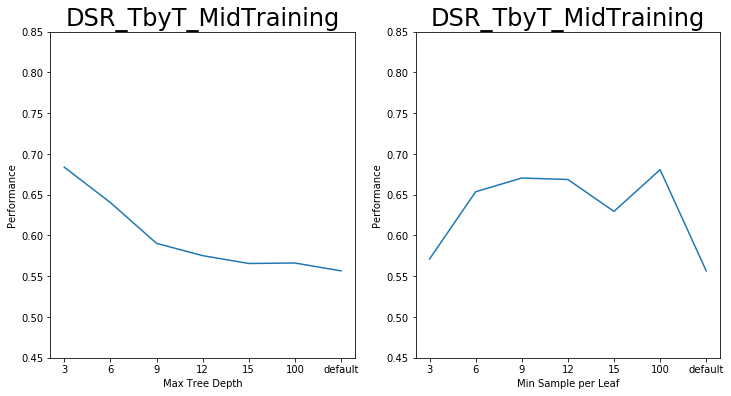

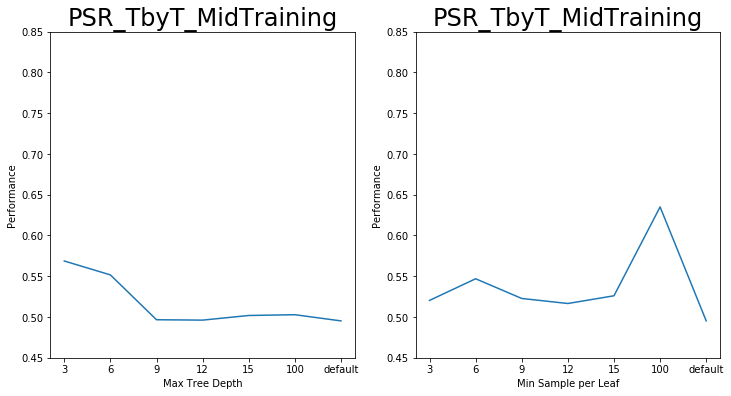

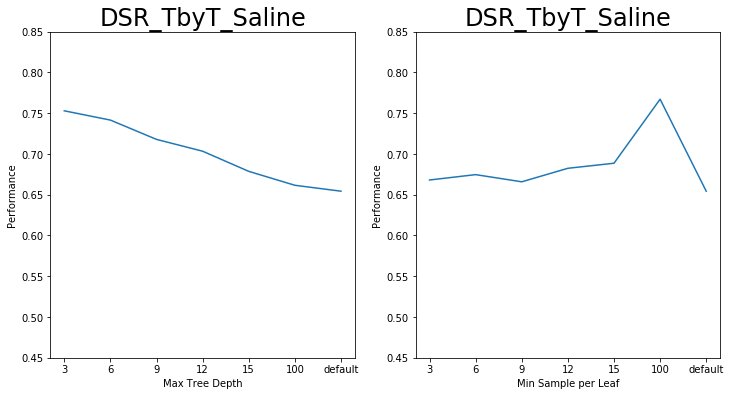

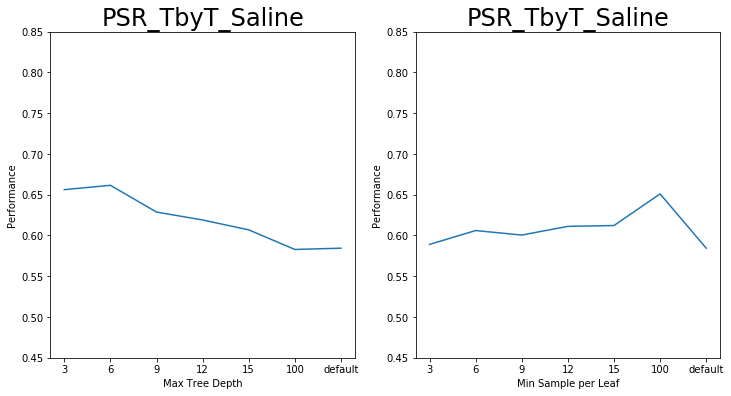

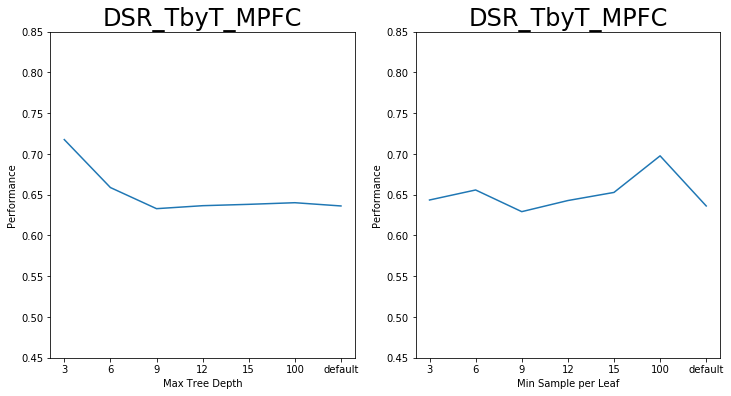

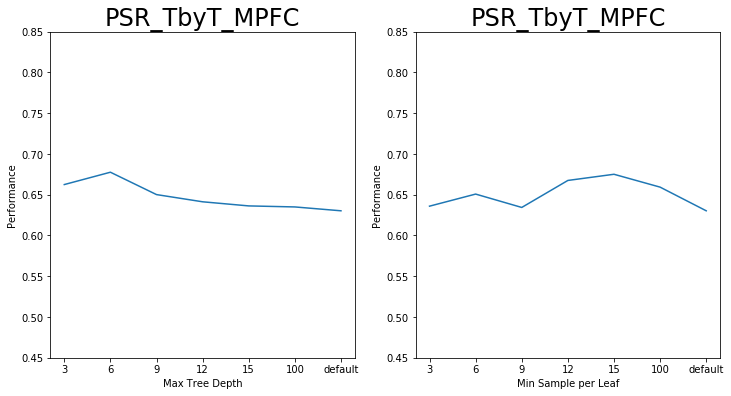

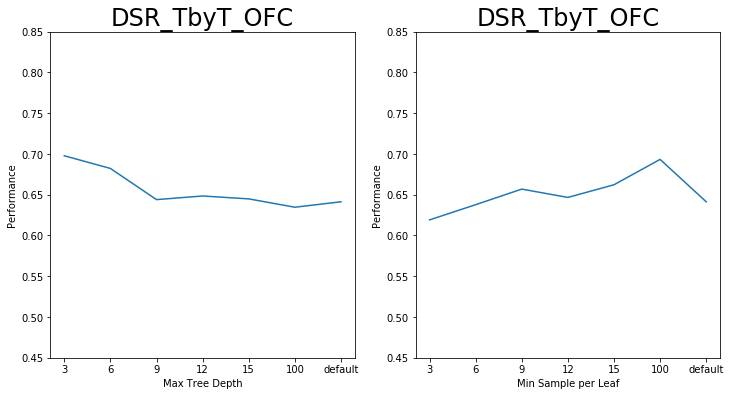

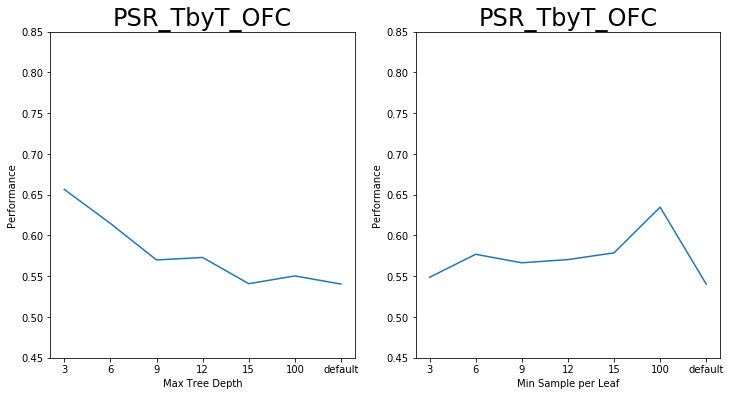

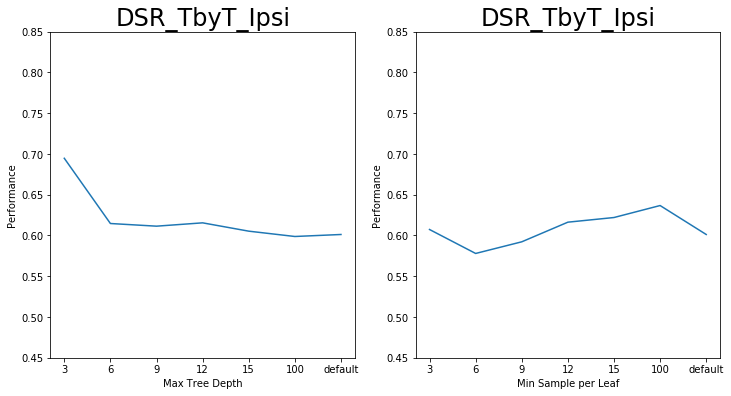

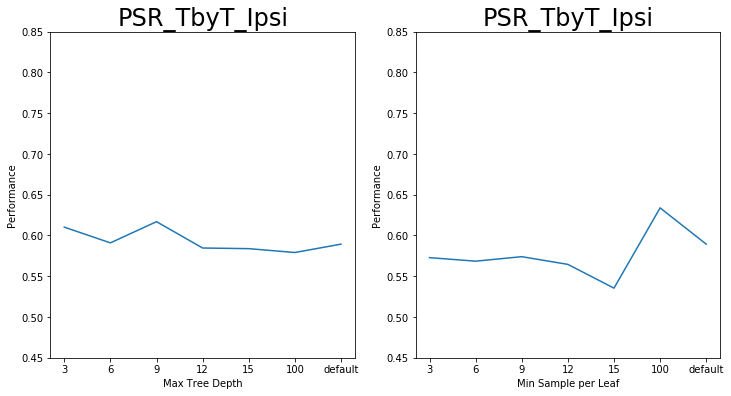

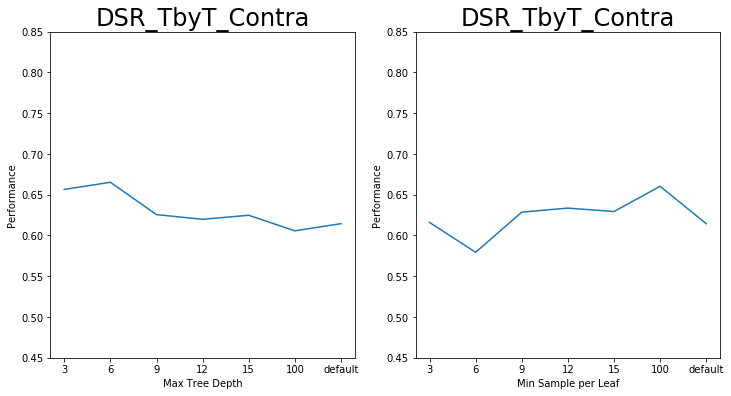

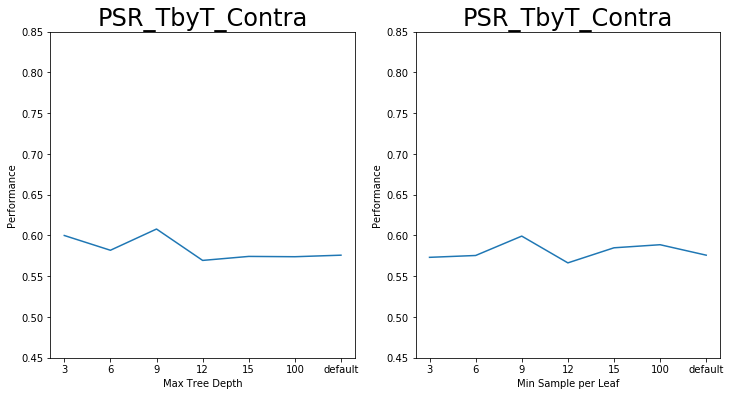

In [54]:
#go thru ALL datasets
for fileName in fileNames:
    X,y = retrieve_dataframe(fileName)
    #still go term by term to see what happens    
    vary_depth_leaf(X, y, ['winStay', 'loseShift', 'choice', 'reward', 'SA', 'RT1', 'RT2', 'choice_AR'], 
                   get_dataset_name(fileName))

And now we repeat this step but with our decision trees that are shallower:

In [55]:
# Create decision tree with default values for now (using gini score)
clf_orig = tree.DecisionTreeClassifier()
clf = tree.DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 100)

#go thru every dataset
for fileName in fileNames:
    X,y = retrieve_dataframe(fileName)
    print 'dataset: %s' %get_dataset_name(fileName)
    print 'score w/default settings: %1.3f' %test_tree(clf_orig, X, y)
    print 'score w/shallower tree: %1.3f' %test_tree(clf, X, y)
    print '-' * 80

dataset: DSR_TbyT_FirstTraining
score w/default settings: 0.603
score w/shallower tree: 0.578
--------------------------------------------------------------------------------
dataset: PSR_TbyT_FirstTraining
score w/default settings: 0.598
score w/shallower tree: 0.655
--------------------------------------------------------------------------------
dataset: DSR_TbyT_MidTraining
score w/default settings: 0.558
score w/shallower tree: 0.681
--------------------------------------------------------------------------------
dataset: PSR_TbyT_MidTraining
score w/default settings: 0.496
score w/shallower tree: 0.592
--------------------------------------------------------------------------------
dataset: DSR_TbyT_Saline
score w/default settings: 0.656
score w/shallower tree: 0.754
--------------------------------------------------------------------------------
dataset: PSR_TbyT_Saline
score w/default settings: 0.584
score w/shallower tree: 0.660
-------------------------------------------------

A significant improvement for most datasets. Now we move on to an ensemble of decision trees: the Random Forest.

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


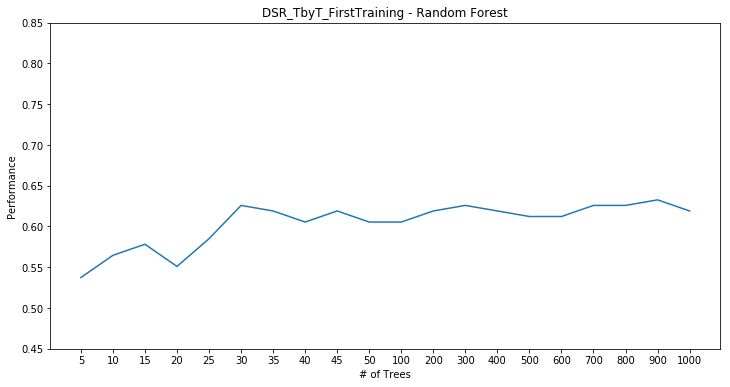

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


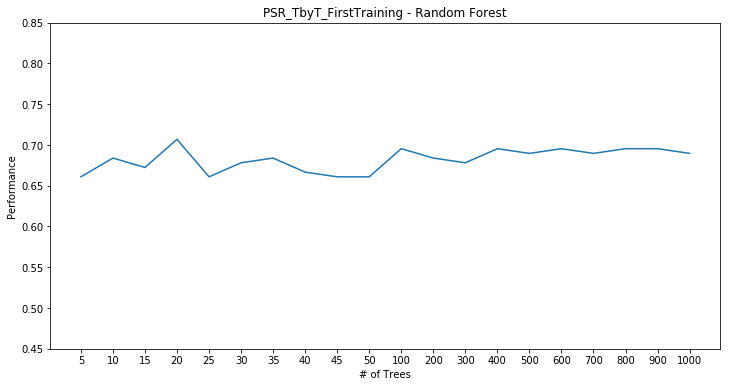

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


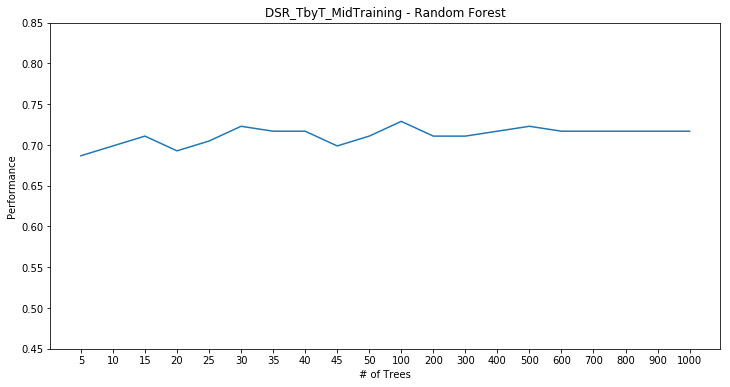

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


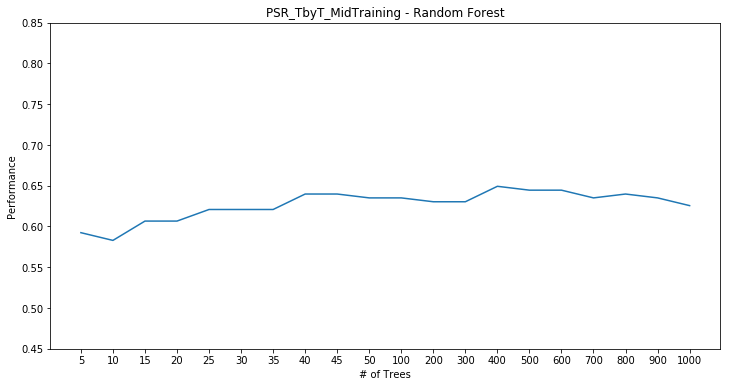

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


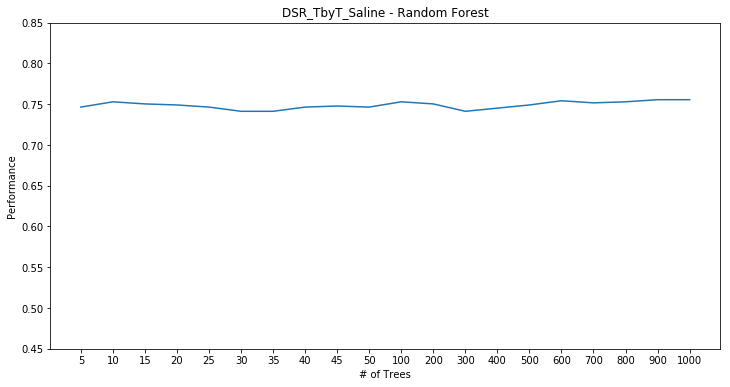

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


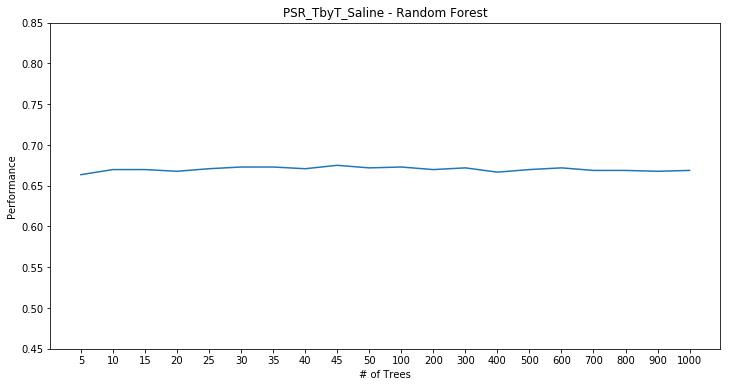

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


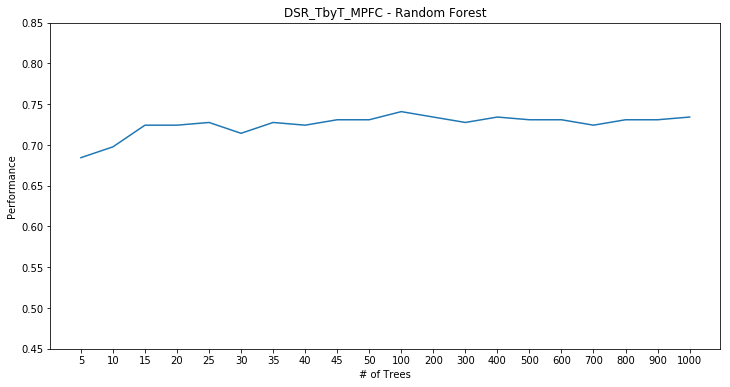

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


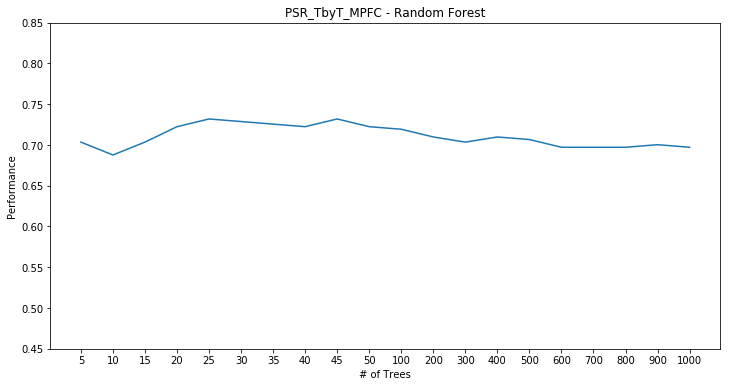

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


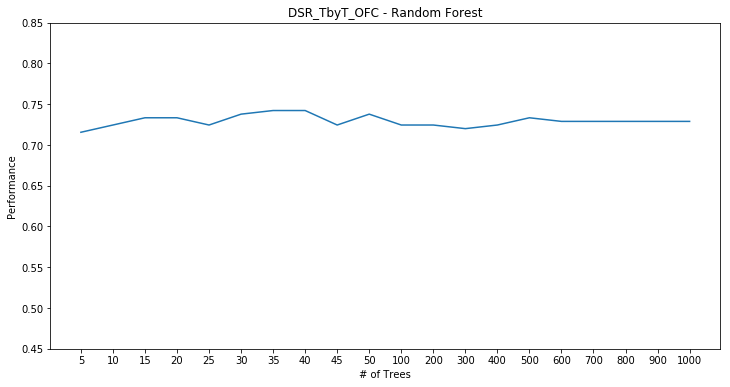

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


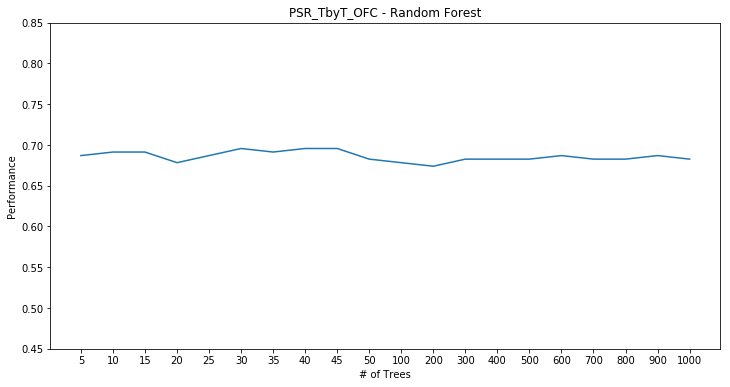

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


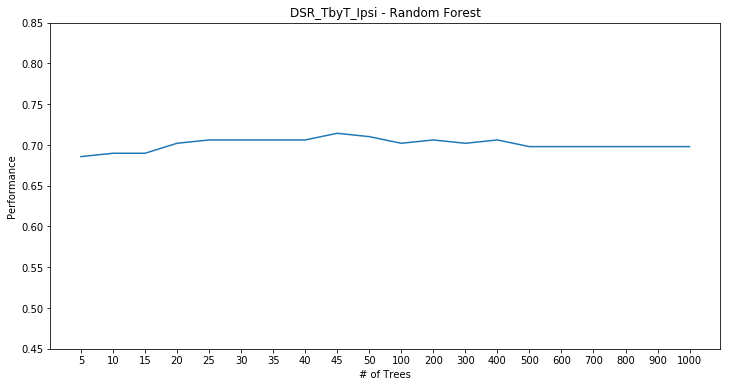

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


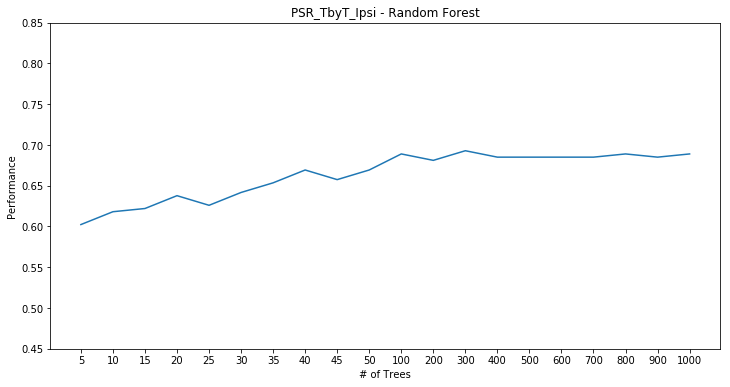

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


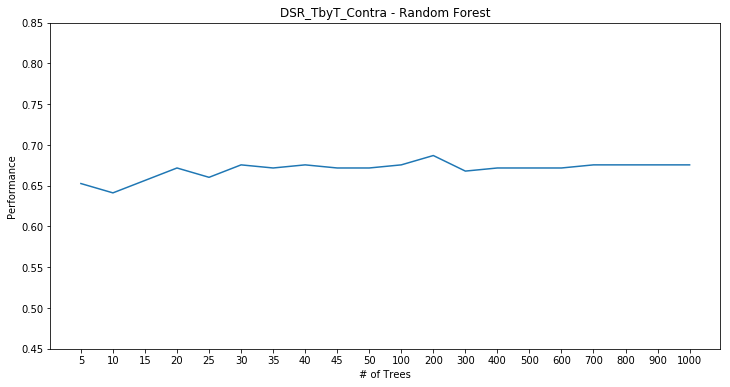

training round 1/20...
training round 2/20...
training round 3/20...
training round 4/20...
training round 5/20...
training round 6/20...
training round 7/20...
training round 8/20...
training round 9/20...
training round 10/20...
training round 11/20...
training round 12/20...
training round 13/20...
training round 14/20...
training round 15/20...
training round 16/20...
training round 17/20...
training round 18/20...
training round 19/20...
training round 20/20...


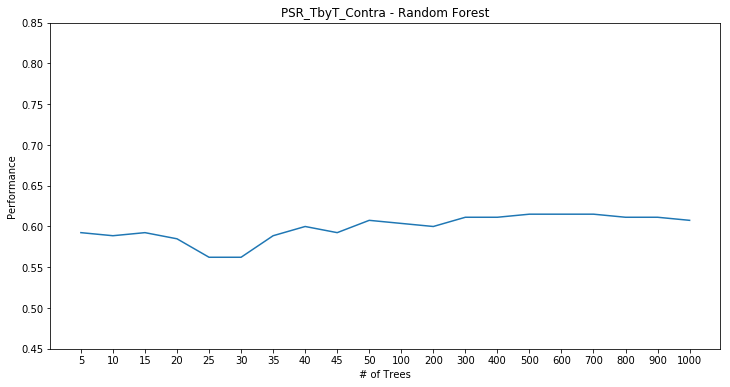

In [67]:
from sklearn.ensemble import RandomForestClassifier

def test_random_forest(RF, X, y):
    #split dataset into train and test sets: 80/20
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)
        
    # Train the classifier
    RF.fit(X_train, y_train)
        
    return RF.score(X_test, y_test)


def vary_trees_random_forest(fileName, treeRange):

    scores = np.zeros(len(treeRange), dtype=float)

    #load dataset
    X,y = retrieve_dataframe(fileName)


    for TRIndex, noTrees in enumerate(treeRange):
        print 'training round %i/%i...' %(TRIndex + 1, len(treeRange))

        RF = RandomForestClassifier(n_estimators = noTrees,
                                    max_depth = 3,
                                    min_samples_leaf = 100,
                                    random_state = 0,
                                    warm_start = True)
        scores[TRIndex] = test_random_forest(RF, X, y)
    
    return scores
    
def plot_random_forest_perf(scores, treeRange, title):

    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(range(len(scores)), scores)
    ax.set_ylim([0.45,0.85])

    ax.set_xticks(range(len(scores)))
    ax.set_xticklabels(treeRange)
    ax.set_xlabel('# of Trees')
    ax.set_ylabel('Performance')
    ax.set_title('%s - Random Forest' %title)
    plt.show()
    
    
#going to vary # of trees in the forest
treeRange = np.r_[np.linspace(5,50,10, dtype=int), np.arange(100,1010,100, dtype=int)]
#go thru a couple of datasets
for fileName in fileNames:
    scores = vary_trees_random_forest(fileName, treeRange)
    plot_random_forest_perf(scores, treeRange, get_dataset_name(fileName))
    


Well, adding more trees has marginal classification improvement. In most cases, 50 trees seems to overcome the initial slump. Let's try lower values of trees and maximum depth and minimum samples per leaf. Technically this should give us best fit, at the expense of computation. For this reason, we'll try a lot less trees.  

If this gives us different results than above, this means that trying to optimize a single decision tree before turning to random forests makes no sense. 

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


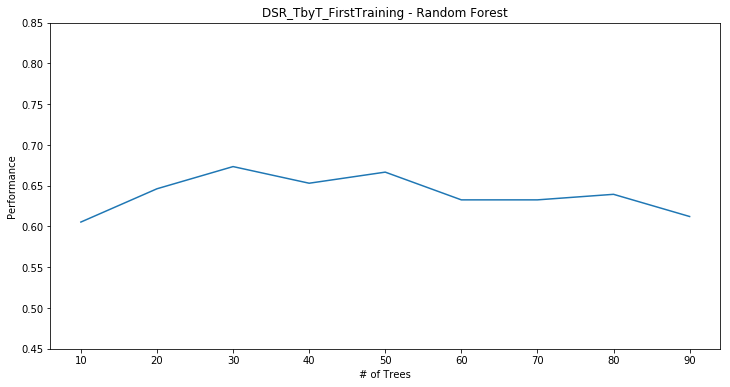

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


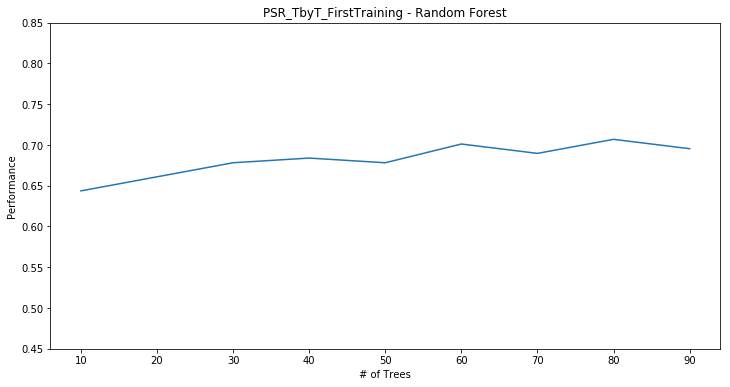

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


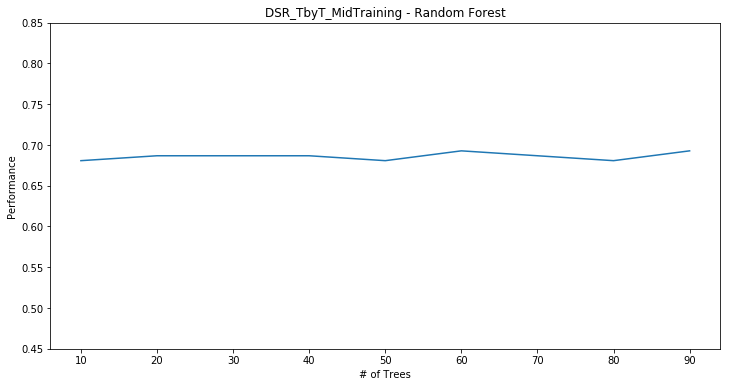

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


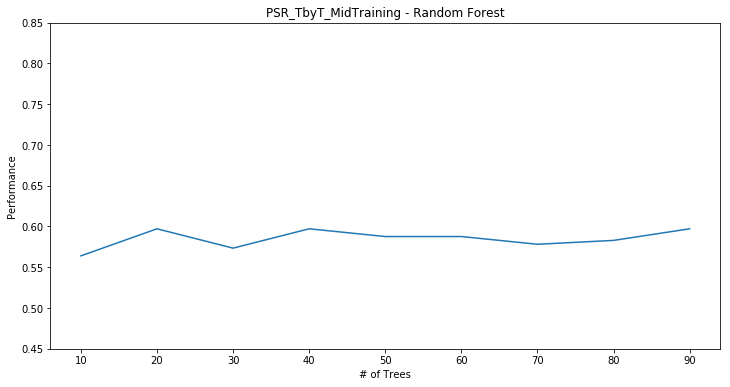

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


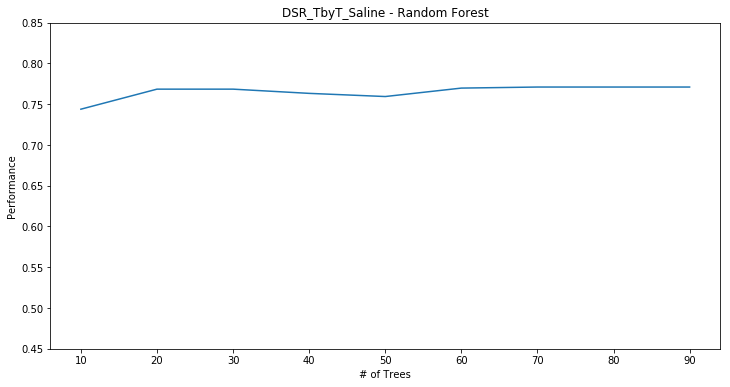

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


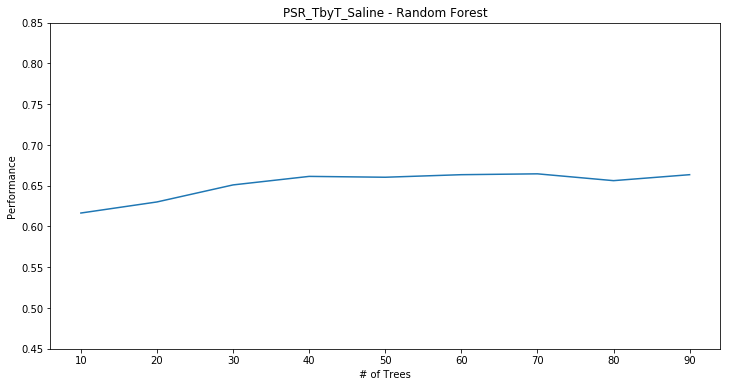

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


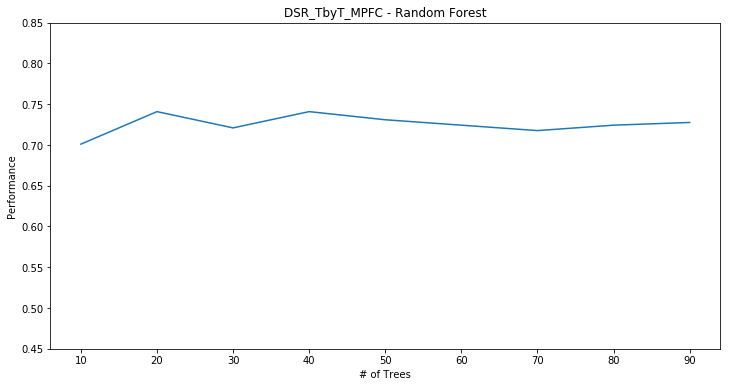

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


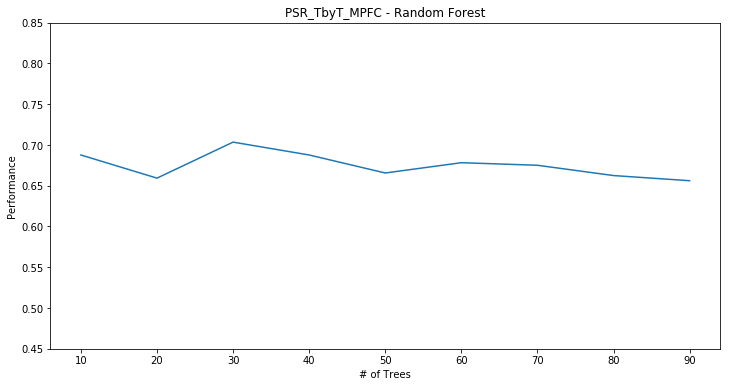

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


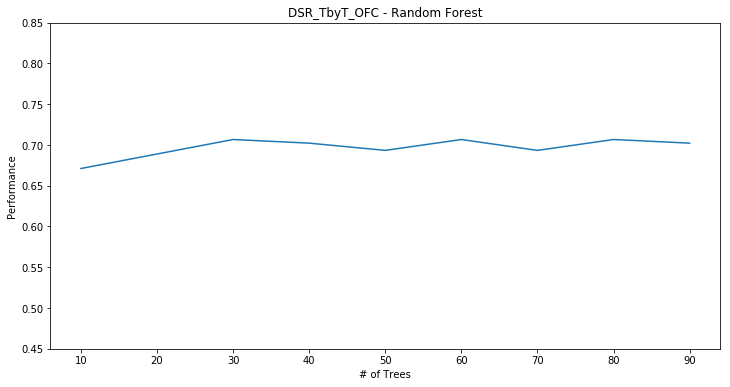

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


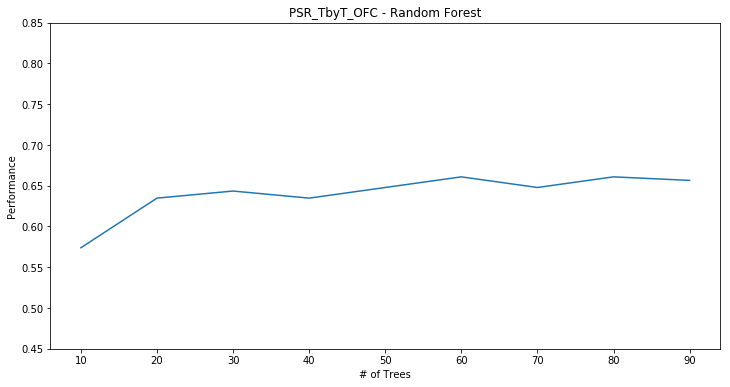

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


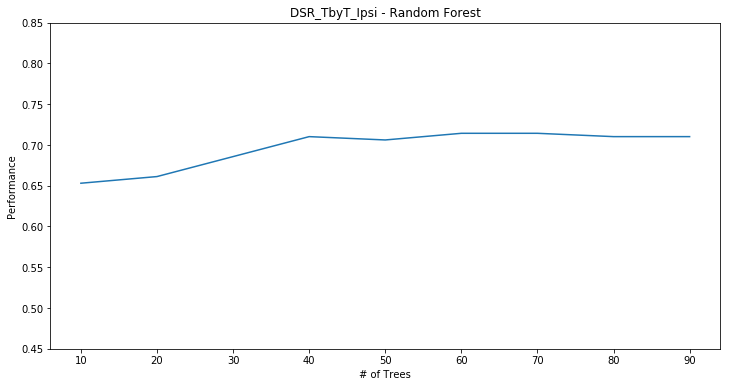

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


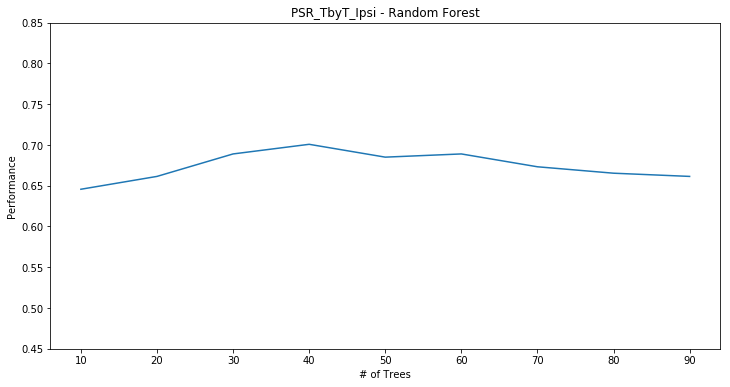

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


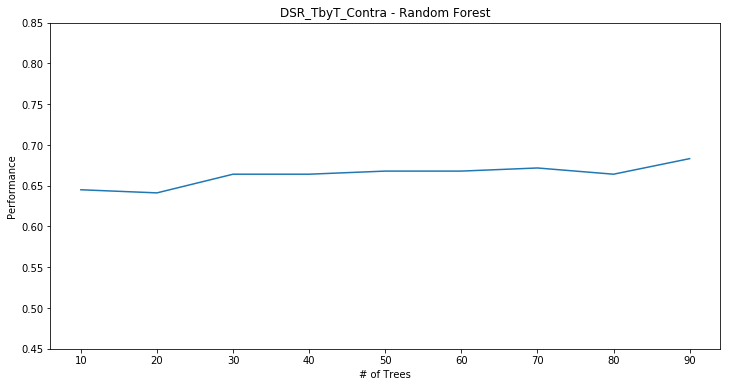

training round 1/9...
training round 2/9...
training round 3/9...
training round 4/9...
training round 5/9...
training round 6/9...
training round 7/9...
training round 8/9...
training round 9/9...


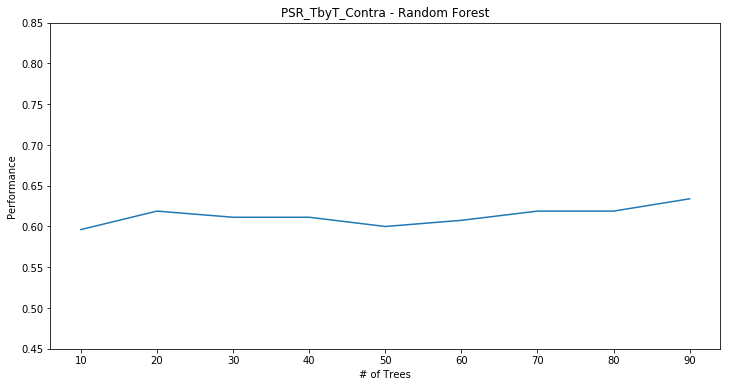

In [68]:
def unlimited_depth_RF(fileName):
    treeRange = np.arange(10,100,10)
    scores = np.zeros(len(treeRange), dtype=float)

    #load dataset
    X,y = retrieve_dataframe(fileName)


    for TRIndex, noTrees in enumerate(treeRange):
        print 'training round %i/%i...' %(TRIndex + 1, len(treeRange))

        RF = RandomForestClassifier(n_estimators = noTrees,
                                    random_state = 0,
                                    warm_start = True)
        scores[TRIndex] = test_random_forest(RF, X, y)

    plot_random_forest_perf(scores, treeRange, get_dataset_name(fileName))
    
#go thru a couple of datasets
for fileName in fileNames:
    unlimited_depth_RF(fileName)


Not sure this made any difference. It may be that optimizing the tree before the random forest made us reach optimal performance right away. It may, however, still give us different results when it comes to giving individual features more or less importance. Also, we'll use 50 trees as it seemed to make no difference, AND also because computation time was also not an issue.  

One last thing we will check, however, is we will vary the max_features to consider at every node of every decision trees. The original Random Forest paper says this is a sensitive variable. So we will try this last optimization with 50 trees! We do run into some bias issues, so we'll proceed with caution since I don't want to split the dataset any further. 

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


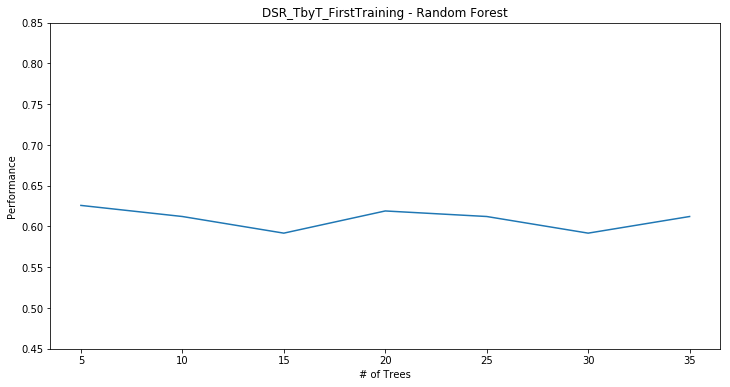

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


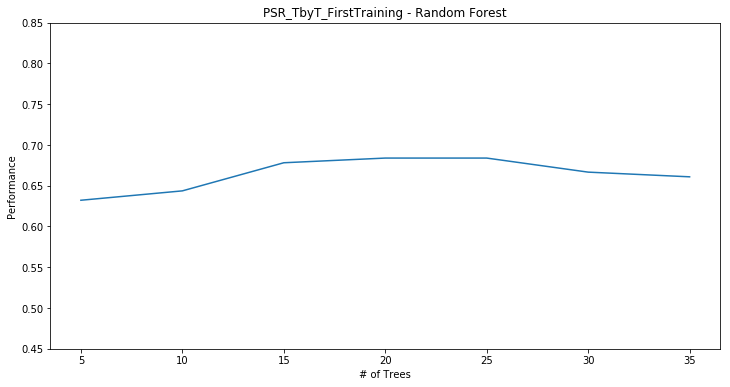

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


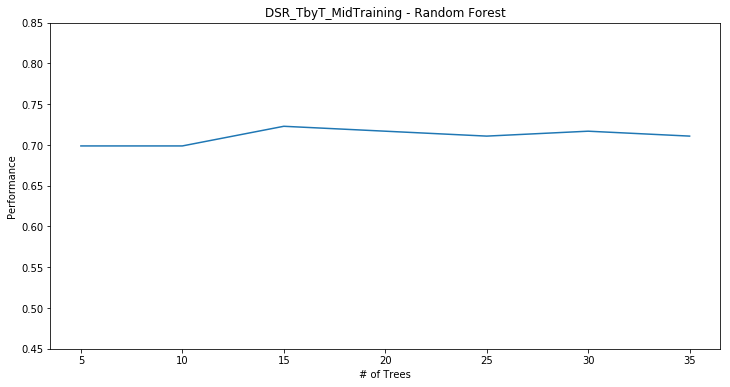

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


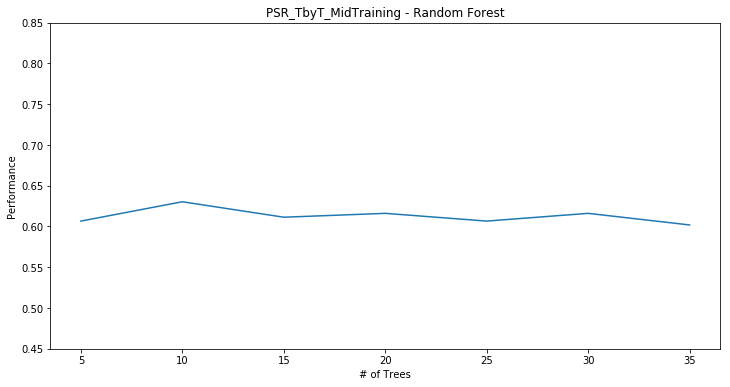

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


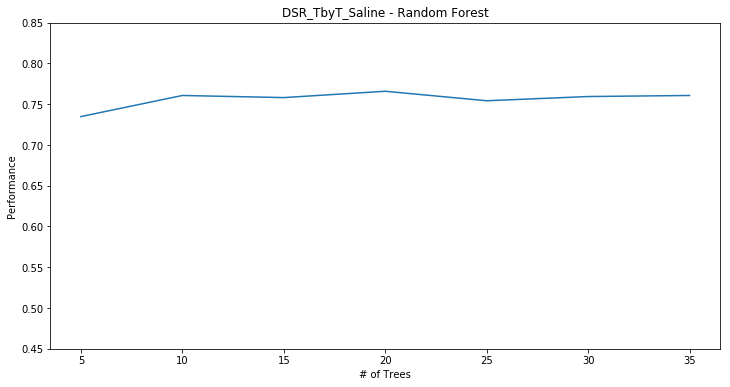

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


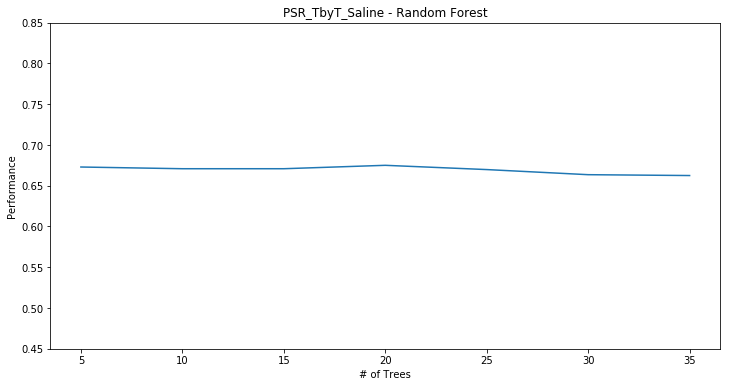

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


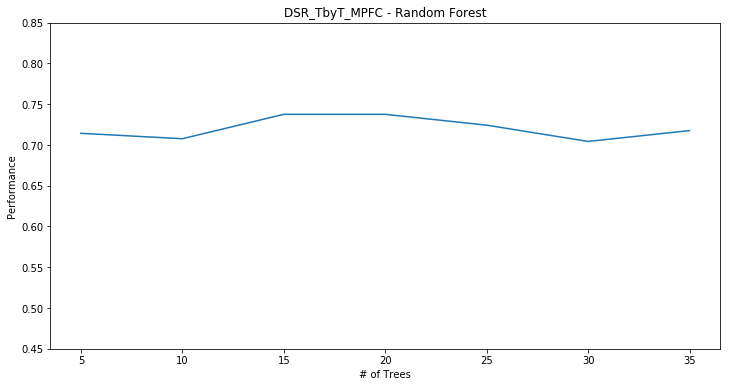

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


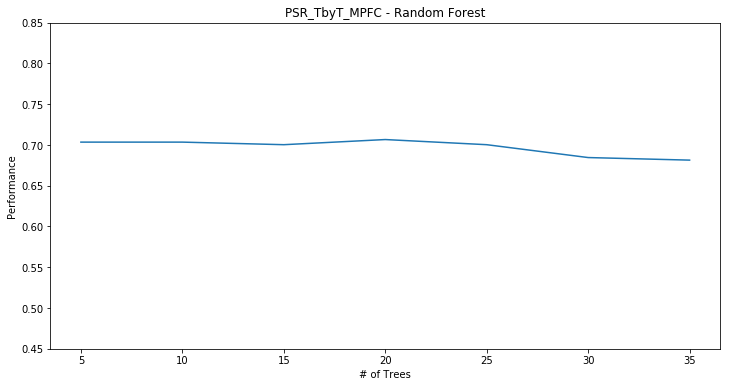

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


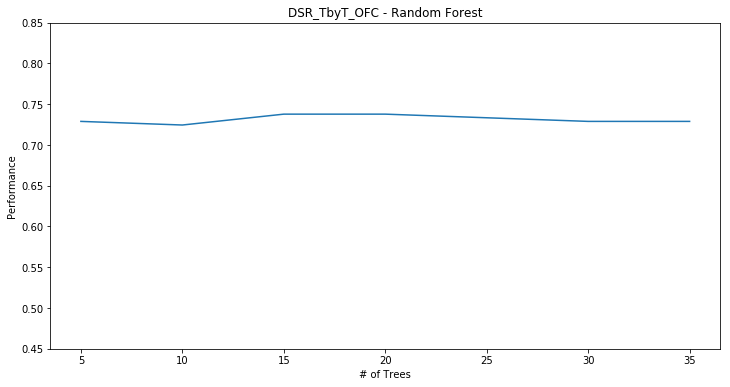

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


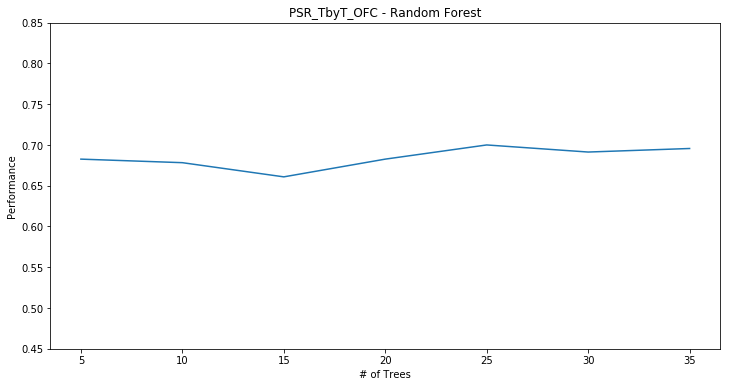

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


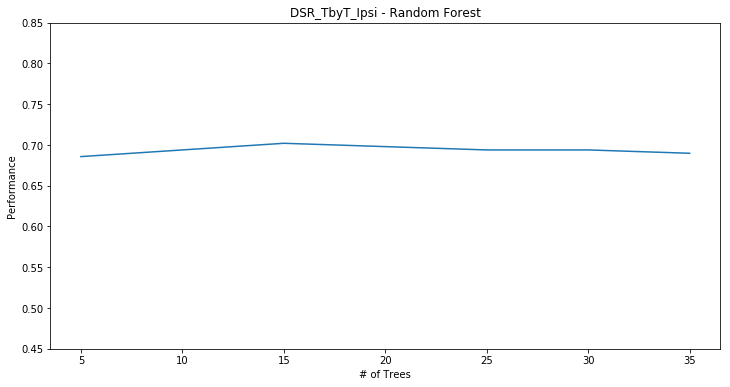

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


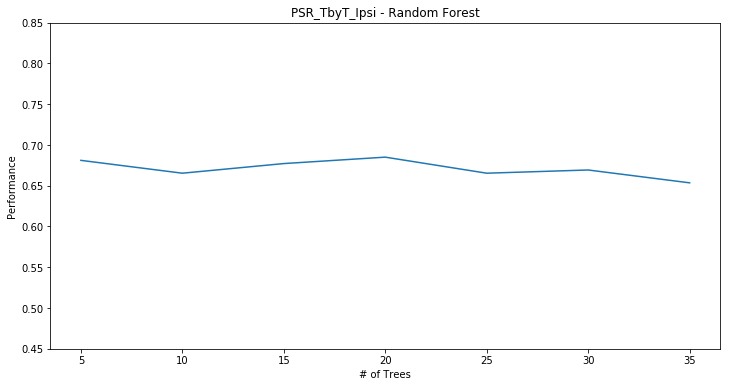

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


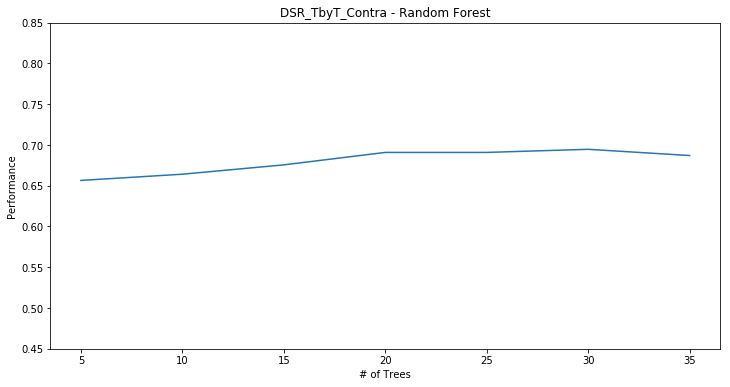

training round 1/7...
training round 2/7...
training round 3/7...
training round 4/7...
training round 5/7...
training round 6/7...
training round 7/7...


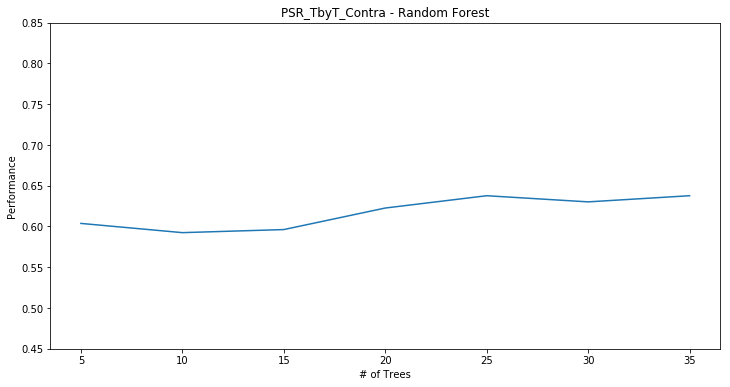

In [81]:
def vary_max_features_random_forest(fileName, maxFeatureRange):

    scores = np.zeros(len(maxFeatureRange), dtype=float)

    #load dataset
    X,y = retrieve_dataframe(fileName)


    for mfIndex, maxFeatures in enumerate(maxFeatureRange):
        print 'training round %i/%i...' %(mfIndex + 1, len(maxFeatureRange))

        RF = RandomForestClassifier(n_estimators = 50,
                                    max_depth = 3,
                                    min_samples_leaf = 100,
                                    random_state = 0,
                                    warm_start = True,
                                    max_features = maxFeatures)
        
        scores[mfIndex] = test_random_forest(RF, X, y)
    
    return scores


#go thru a couple of datasets
for fileName in fileNames:
    #we need the dimensions of the data to make the appropriate range
    X,y = retrieve_dataframe(fileName)
    noFeatures = X.shape[1]
    #going to vary max features, must be at most half of # of features
    maxFeatureRange = np.arange(5, noFeatures / 2, 5, dtype=int)
    #train classifiers
    scores = vary_max_features_random_forest(fileName, maxFeatureRange)
    #plot results
    plot_random_forest_perf(scores, maxFeatureRange, get_dataset_name(fileName))
    


Most of these are pretty flat, so we're gonna leave the default value sqrt(# of features) which was ~ 8 in all these datasets. Finally, we have:

********************************************************************************
dataset: DSR_TbyT_FirstTraining
score on test set:0.62


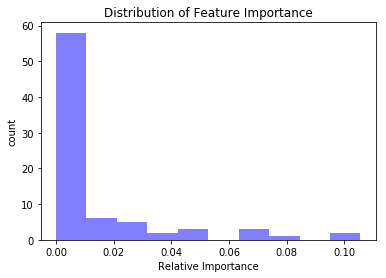

features that made it:
RT1_5 - val:0.027
RT1_6 - val:0.022
choice_1 - val:0.028
choice_2 - val:0.097
choice_3 - val:0.048
choice_4 - val:0.072
choice_5 - val:0.106
choice_6 - val:0.020
choice_8 - val:0.079
choice_10 - val:0.036
choice_AR_2 - val:0.031
choice_AR_4 - val:0.021
choice_AR_5 - val:0.064
choice_AR_6 - val:0.069
choice_AR_7 - val:0.045
choice_AR_8 - val:0.046
choice_AR_10 - val:0.034

features that did NOT make it:
RT1_1 - val:0.017
RT1_2 - val:0.005
RT1_3 - val:0.005
RT1_4 - val:0.000
RT1_7 - val:0.003
RT1_8 - val:0.013
RT1_9 - val:0.000
RT1_10 - val:0.000
RT2_1 - val:0.004
RT2_2 - val:0.002
RT2_3 - val:0.000
RT2_4 - val:0.017
RT2_5 - val:0.006
RT2_6 - val:0.000
RT2_7 - val:0.007
RT2_8 - val:0.000
RT2_9 - val:0.010
RT2_10 - val:0.006
SA_1 - val:0.000
SA_2 - val:0.003
SA_3 - val:0.000
SA_4 - val:0.007
SA_5 - val:0.000
SA_6 - val:0.000
SA_7 - val:0.000
SA_8 - val:0.005
SA_9 - val:0.009
SA_10 - val:0.000
choice_7 - val:0.000
choice_9 - val:0.006
choice_AR_1 - val:0.000
choice_A

In [77]:
def plot_coeff_distributions(fileName):

    X,y = retrieve_dataframe(fileName)

    #split dataset into train and test sets: 80/20
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)

    RF = RandomForestClassifier(n_estimators = 50,
                                max_depth = 3,
                                min_samples_leaf = 100,
                                random_state = 0,
                                warm_start = True)
    RF.fit(X_train, y_train)
    print 'score on test set:%1.2f' %RF.score(X_test, y_test)

    plt.hist(RF.feature_importances_, 10, facecolor='blue', alpha=0.5)
    plt.ylabel('count')
    plt.xlabel('Relative Importance')
    plt.title('Distribution of Feature Importance')
    plt.show()

    return X, RF

def print_feature_labels(X, RF, cutoff = 0.02):
    feature_labels = [str(X.columns.levels[0][a]) + '_' +  str(X.columns.levels[1][b]) \
                     for a,b in zip(X.columns.labels[0], X.columns.labels[1])]

    print 'features that made it:'
    for i, fl in enumerate(feature_labels):
        if RF.feature_importances_[i] > cutoff:
            print '%s - val:%1.3f' %(fl,  RF.feature_importances_[i])

    print '\nfeatures that did NOT make it:'
    for i, fl in enumerate(feature_labels):
        if RF.feature_importances_[i] <= cutoff:
            print '%s - val:%1.3f' %(fl,  RF.feature_importances_[i])
            


features = ['choice','SA','winStay','loseShift','reward', 'choice_AR', 'RT1', 'RT2', 'congruent'] 
for fileName in fileNames[0:1]:
    print '*' * 80
    print 'dataset: %s' %get_dataset_name(fileName)
    X, RF = plot_coeff_distributions(fileName)
    print_feature_labels(X, RF)


This is a huge sanity check. Most of the features above the arbitrary 0.02 value are choice and choice_AR, which we found were good predictors. Since 0.02 is arbitrary, we will keep the 30 features with the top score. We will then save the dataset to a target folder.

In [78]:
import os
target = '/Users/pablomartin/python/DATA_structures/featureSelection/'

def reduce_datasets(fileName, features_to_keep = 30):
    #dataset name
    dataset_filename = get_dataset_name(fileName)
    X,y = retrieve_dataframe(fileName)
    
    #split dataset into train and test sets: 80/20
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)

    RF = RandomForestClassifier(n_estimators = 50,
                                max_depth = 3,
                                min_samples_leaf = 100,
                                random_state = 0,
                                warm_start = True)
    RF.fit(X_train, y_train)
    print 'score on test set:%1.2f' %RF.score(X_test, y_test)

    
    sortedIndex = np.argsort(RF.feature_importances_)[::-1]
    featureFilter = [X.columns.values[a] for a in sortedIndex[:features_to_keep]]
    tmpX = X[featureFilter]
    tmpX.sort_index(axis=1, inplace=True)
    
    dataPair = [tmpX, y]
    
    pickle.dump(dataPair, open(target + dataset_filename + '.p', 'wb')) 
    
    print 'done with dataset %s...' %dataset_filename
    return 


for fileName in fileNames:
    #keep top 30 features of each dataset
    reduce_datasets(fileName, features_to_keep = 30)


score on test set:0.61
done with dataset DSR_TbyT_FirstTraining...
score on test set:0.66
done with dataset PSR_TbyT_FirstTraining...
score on test set:0.71
done with dataset DSR_TbyT_MidTraining...
score on test set:0.64
done with dataset PSR_TbyT_MidTraining...
score on test set:0.75
done with dataset DSR_TbyT_Saline...
score on test set:0.67
done with dataset PSR_TbyT_Saline...
score on test set:0.73
done with dataset DSR_TbyT_MPFC...
score on test set:0.72
done with dataset PSR_TbyT_MPFC...
score on test set:0.74
done with dataset DSR_TbyT_OFC...
score on test set:0.68
done with dataset PSR_TbyT_OFC...
score on test set:0.71
done with dataset DSR_TbyT_Ipsi...
score on test set:0.67
done with dataset PSR_TbyT_Ipsi...
score on test set:0.67
done with dataset DSR_TbyT_Contra...
score on test set:0.61
done with dataset PSR_TbyT_Contra...


And we are done with feature selection.